In [ ]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install torch==2.3.0 transformers==4.41.2 huggingface_hub --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/779.1 MB 5.2 MB/s eta 0:01:48
ERROR: Operation cancelled by user
^C


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import emoji

In [ ]:

df = pd.read_csv("Final_data.csv", encoding='latin1')

In [ ]:
df.head(4)

text  Category
0  i am year old junior in college i have multipl...  distress
1  Remember when your mom said eating all that ju...  distress
2  wish days could go emotional void turn numb li...  distress
3  so i started having suicidal thought in april ...  distress

In [ ]:

df["Category"].value_counts()

Category
distress    500
Humor       500
Sarcasam    500
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Category'>

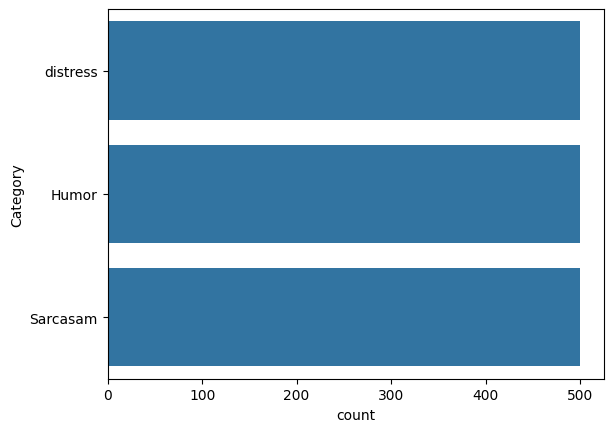

In [ ]:
sns.countplot(df["Category"])

In [ ]:


def clean_texts(text):
    cleantext = emoji.replace_emoji(text, replace='')
    cleantext = re.sub(r'http\S+\s', ' ', text)
    cleantext = re.sub(r'@\S+', ' ', cleantext)
    cleantext = re.sub(r'#\S+', ' ', cleantext)
    cleantext = re.sub(r'@\S+', ' ', cleantext)
    cleantext = re.sub(r'[%s]' % re.escape(r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', cleantext)
    cleantext = re.sub(r'[0-9]+', ' ', cleantext)
    cleantext = re.sub(r'[^\x00-\x7f]', r' ', cleantext)
    cleantext = re.sub(r'\s+', ' ', cleantext)
    return cleantext

In [ ]:
clean_texts("11 Remember when your mom said eating all that junk food was going to make you sick? Well, she wasn't wrong. Anxiety, depression, mental disorders are really gut #biome disorders. #LoveYourBiome  https://www.bbc.com/news/health-43815370ÃÂ Ã¢ÂÂ¦")

' Remember when your mom said eating all that junk food was going to make you sick Well she wasn t wrong Anxiety depression mental disorders are really gut disorders '

In [ ]:
df["text"]= df["text"].apply(lambda x: clean_texts(x))

In [ ]:
df["text"][10]

'check profile see currently hospitalized selfharm watch trying organize things yesterday found bunch notes different people really cared about read mine undoubtedly hardest thing ever do could get hold hospital called mom could inform doctor since supposed see right now mom nearly demanding turn notes really wants read them refused saying something anyone ever read read sure addressed me question is asshole giving notes right thing found exgfs suicide notes'

In [ ]:

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])

# **BERT**

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

embeddings_list = []

for text in tqdm(df['text'], desc="Encoding tweets"):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=256)

    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    embeddings_list.append(cls_embedding)

df["bert_embedding"] = embeddings_list


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
df["bert_embedding"].head(5)

0    [-0.10165681, -0.09327857, 0.19922267, -0.3457...
1    [0.37525958, 0.28796604, -0.34381527, -0.09081...
2    [0.0524259, 0.13875367, 0.45757806, 0.01045625...
3    [-0.12887585, 0.20873962, 0.16682494, -0.34675...
4    [-0.050421868, 0.046490766, 0.54763186, -0.543...
Name: bert_embedding, dtype: object

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional

X = np.stack(df['bert_embedding'].values)
y = df['Category'].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


# **BERT + BI-LSTM**

```
# This is formatted as code
```



In [ ]:

from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Reshape
from tensorflow.keras.models import Model

input_dim = 768  # BERT CLS embedding size
num_classes = len(label_encoder.classes_)

inputs = Input(shape=(input_dim,), name='bert_input')

# Replace Lambda with Reshape
x = Reshape((1, input_dim))(inputs)

x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bert_input (InputLayer)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       426,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,291 (1.76 MB)

 Trainable params: 460,291 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.7004 - loss: 0.7781 - val_accuracy: 0.9400 - val_loss: 0.1732
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9336 - loss: 0.1997 - val_accuracy: 0.9533 - val_loss: 0.1605
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9491 - loss: 0.1429 - val_accuracy: 0.9533 - val_loss: 0.1704
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9697 - loss: 0.0935 - val_accuracy: 0.9300 - val_loss: 0.2370
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9547 - loss: 0.1136 - val_accuracy: 0.9467 - val_loss: 0.1788


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


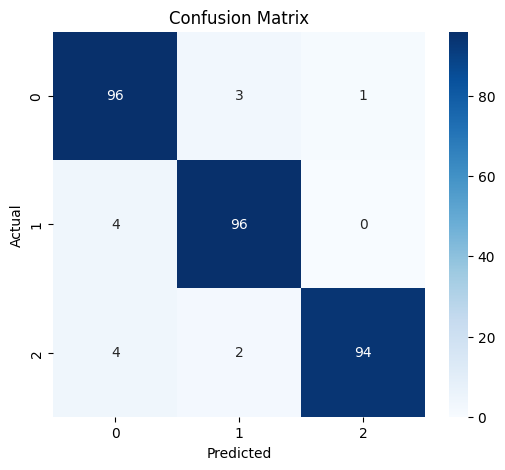

In [ ]:

y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


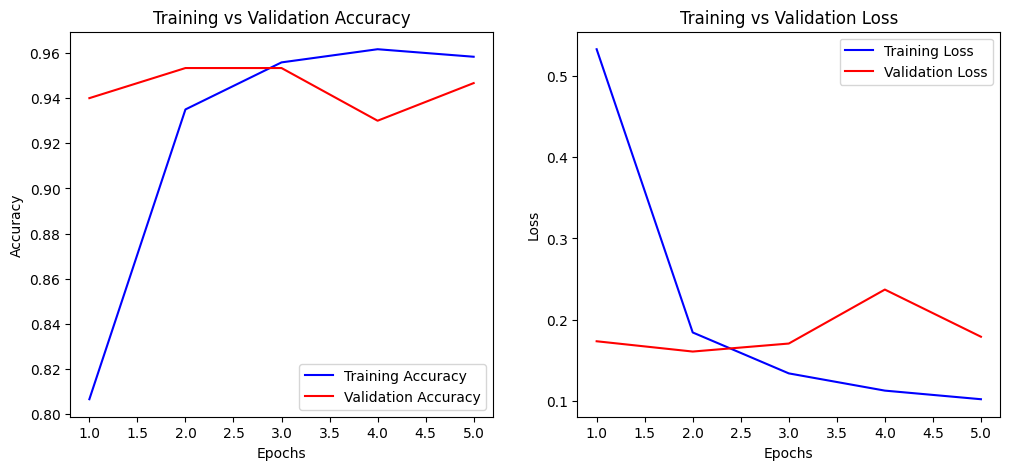

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


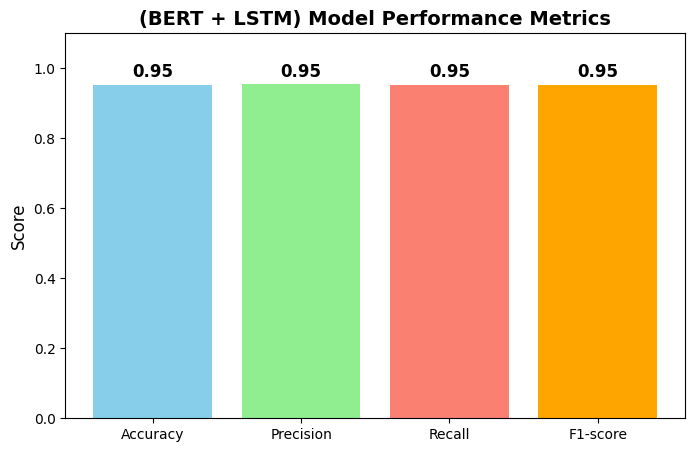

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]


plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])


for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + LSTM**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

input_dim = 768
num_classes = len(label_encoder.classes_)


inputs = Input(shape=(input_dim,), name='bert_input')
x = Reshape((1, input_dim))(inputs)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)


outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bert_input (InputLayer)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,059 (1.88 MB)

 Trainable params: 493,059 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.3737 - loss: 1.0926 - val_accuracy: 0.8567 - val_loss: 0.9770
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6923 - loss: 0.9589 - val_accuracy: 0.9167 - val_loss: 0.7741
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7949 - loss: 0.7771 - val_accuracy: 0.9233 - val_loss: 0.5237
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8690 - loss: 0.5587 - val_accuracy: 0.9233 - val_loss: 0.3459
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8804 - loss: 0.4263 - val_accuracy: 0.9300 - val_loss: 0.2545
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9143 - loss: 0.3172 - val_accuracy: 0.9333 - val_loss: 0.2110
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9169 - loss: 0.2703 - val_accuracy: 0.9367 - val_loss: 0.1881
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9308 - loss: 0.2311 - val_accuracy: 0.9433 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


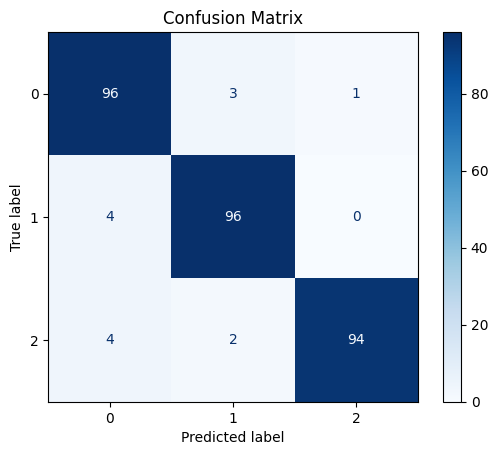

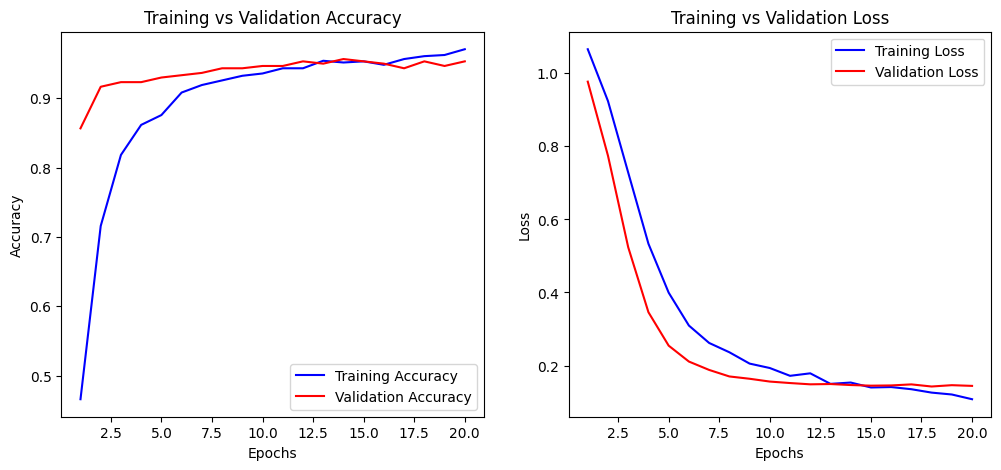

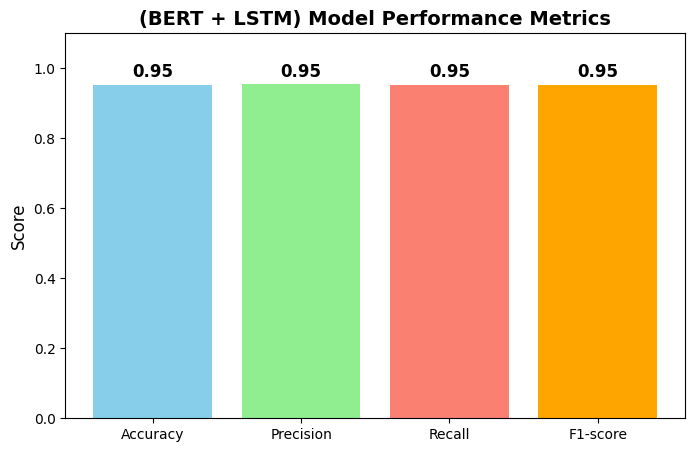

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + BILSTM**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Bidirectional, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


input_dim = 768
num_classes = len(label_encoder.classes_)

inputs = Input(shape=(input_dim,), name='bert_input')
x = Reshape((1, input_dim))(inputs)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bert_input (InputLayer)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       918,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,091 (3.76 MB)

 Trainable params: 985,091 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4276 - loss: 1.0665 - val_accuracy: 0.8833 - val_loss: 0.8763
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7296 - loss: 0.8724 - val_accuracy: 0.9167 - val_loss: 0.5829
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8585 - loss: 0.6020 - val_accuracy: 0.9233 - val_loss: 0.3504
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9044 - loss: 0.4006 - val_accuracy: 0.9400 - val_loss: 0.2479
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9102 - loss: 0.3140 - val_accuracy: 0.9433 - val_loss: 0.2032
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9051 - loss: 0.2735 - val_accuracy: 0.9467 - val_loss: 0.1832
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9370 - loss: 0.2227 - val_accuracy: 0.9467 - val_loss: 0.1689
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9464 - loss: 0.1788 - val_accuracy: 0.9500 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


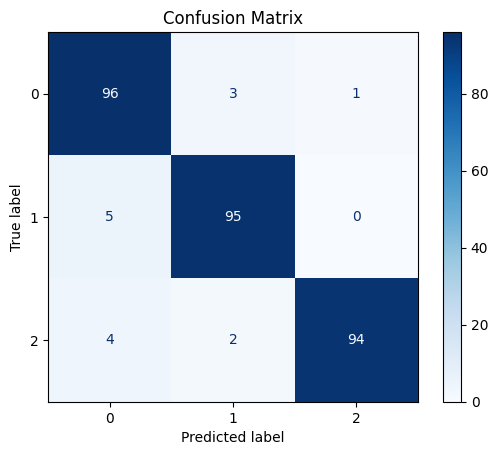

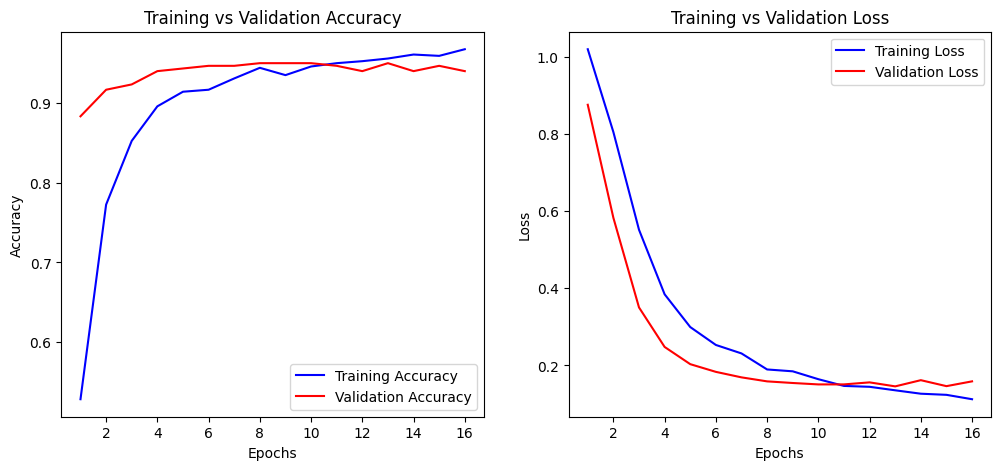

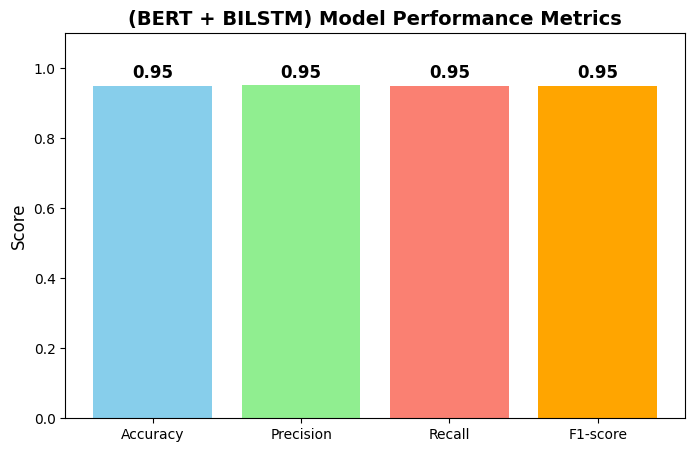

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + GRU**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

input_dim = 768
num_classes = len(label_encoder.classes_)

inputs = Input(shape=(input_dim,), name='bert_input')

# Reshape to fit GRU input (timesteps=1, features=input_dim)
x = Reshape((1, input_dim))(inputs)
x = GRU(128, return_sequences=False)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)


outputs = Dense(num_classes, activation='softmax')(x)


model_GRU = Model(inputs=inputs, outputs=outputs)


model_GRU.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model_GRU.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model_GRU.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bert_input (InputLayer)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 128)            │       344,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,627 (1.44 MB)

 Trainable params: 378,627 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4076 - loss: 1.0902 - val_accuracy: 0.8700 - val_loss: 0.8804
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6584 - loss: 0.8953 - val_accuracy: 0.8967 - val_loss: 0.6653
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8029 - loss: 0.6837 - val_accuracy: 0.9233 - val_loss: 0.4631
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8412 - loss: 0.5351 - val_accuracy: 0.9267 - val_loss: 0.3353
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8775 - loss: 0.4351 - val_accuracy: 0.9267 - val_loss: 0.2629
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8990 - loss: 0.3414 - val_accuracy: 0.9300 - val_loss: 0.2212
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8953 - loss: 0.3141 - val_accuracy: 0.9367 - val_loss: 0.1973
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9109 - loss: 0.2755 - val_accuracy: 0.9500 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


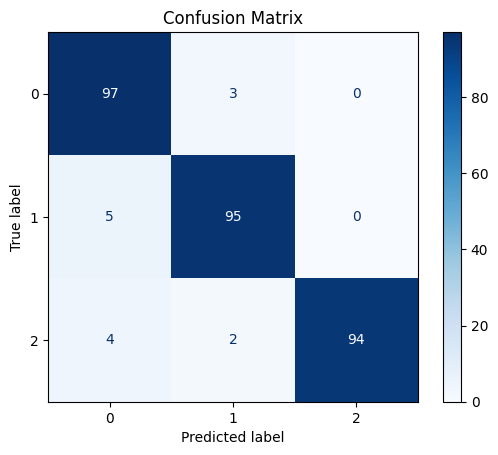

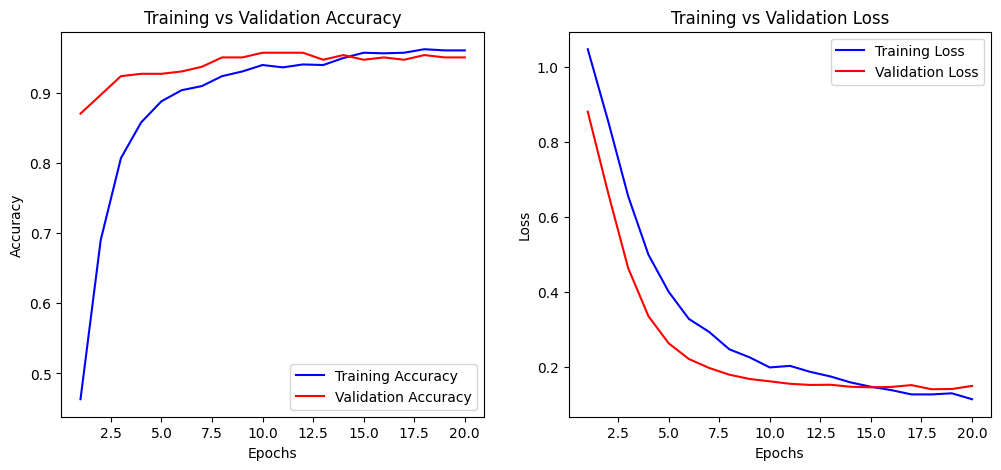

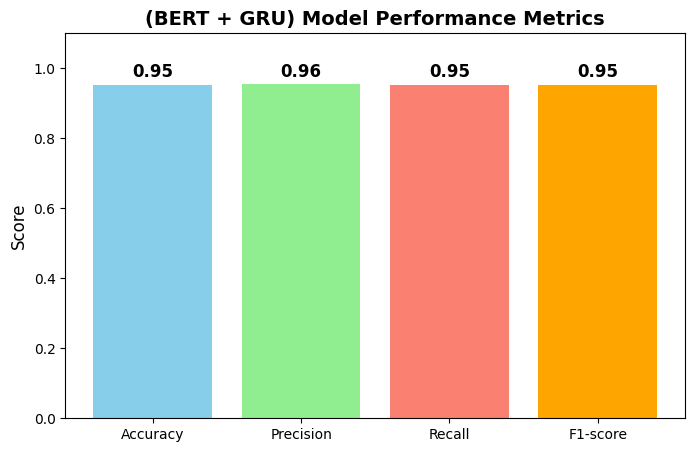

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_probs = model_GRU.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + GRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + BIGRU**

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, Bidirectional, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping


input_dim = 768
num_classes = len(label_encoder.classes_)


inputs = Input(shape=(input_dim,), name='bert_input')


x = Reshape((1, input_dim))(inputs)
x = Bidirectional(GRU(128, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=20,
    callbacks=[early_stop]
)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bert_input (InputLayer)         │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 1, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       689,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,227 (2.88 MB)

 Trainable params: 756,227 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.4528 - loss: 1.0568 - val_accuracy: 0.8500 - val_loss: 0.7662
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7382 - loss: 0.7708 - val_accuracy: 0.9000 - val_loss: 0.4989
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8461 - loss: 0.5644 - val_accuracy: 0.9267 - val_loss: 0.3290
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8822 - loss: 0.4032 - val_accuracy: 0.9300 - val_loss: 0.2551
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9003 - loss: 0.3230 - val_accuracy: 0.9367 - val_loss: 0.2075
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9213 - loss: 0.2682 - val_accuracy: 0.9400 - val_loss: 0.1836
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9165 - loss: 0.2478 - val_accuracy: 0.9400 - val_loss: 0.1676
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9324 - loss: 0.2119 - val_accuracy: 0.9433 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


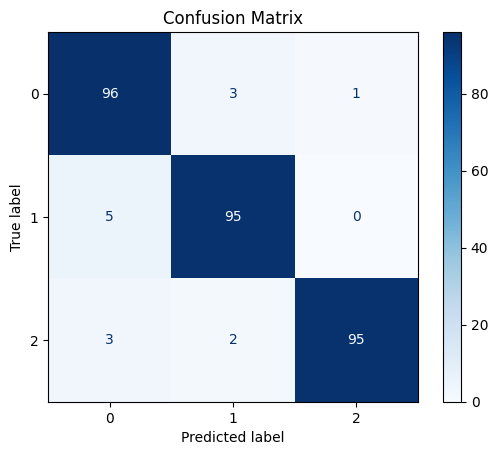

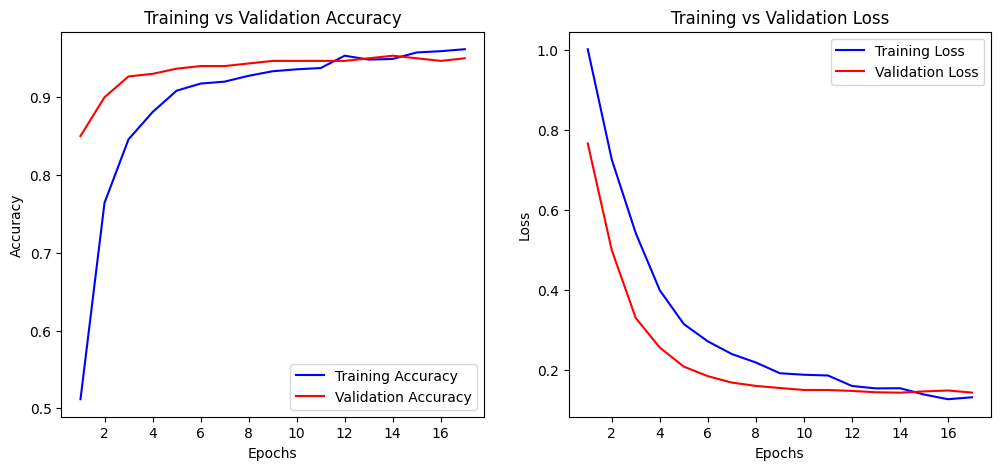

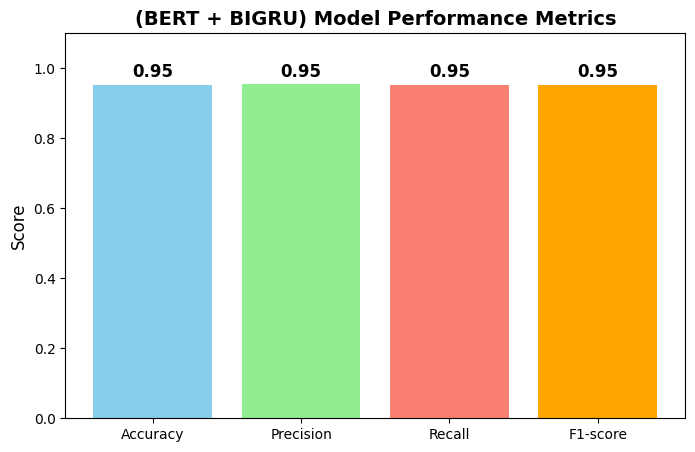

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(BERT + BIGRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + Logistic regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)



LogisticRegression(max_iter=2000)

Accuracy: 0.9466666666666667
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       100
           1       0.96      0.95      0.95       100
           2       0.99      0.93      0.96       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



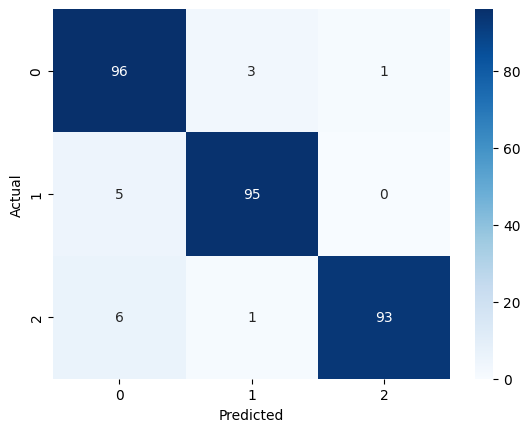

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


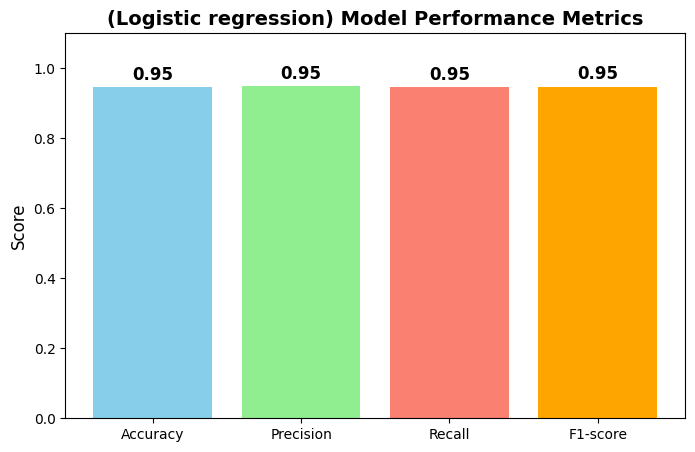

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt



acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(Logistic regression) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + Randomforest classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

r_clf = RandomForestClassifier(n_estimators=200, random_state=42)
r_clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

Accuracy: 0.9533333333333334
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       100
           1       0.96      0.96      0.96       100
           2       1.00      0.92      0.96       100

    accuracy                           0.95       300
   macro avg       0.96      0.95      0.95       300
weighted avg       0.96      0.95      0.95       300



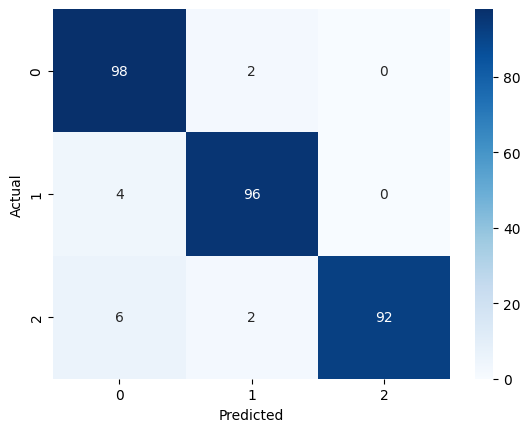

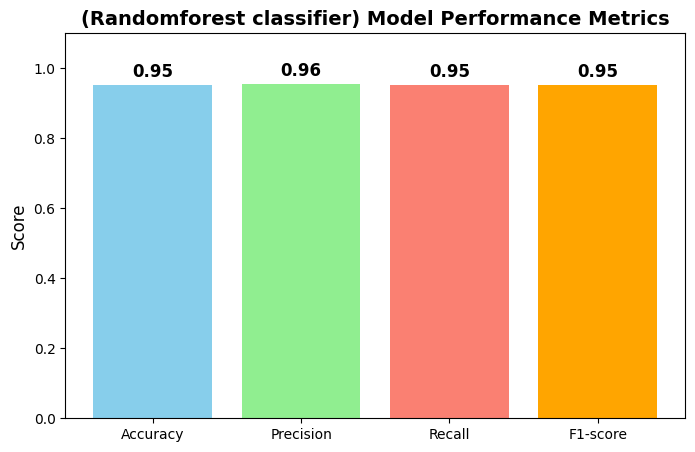

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = r_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(Randomforest classifier) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + XGBOOST**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

clf_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)


clf_xgb.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [18:17:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

Accuracy: 0.9533333333333334
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       100
           1       0.96      0.96      0.96       100
           2       1.00      0.92      0.96       100

    accuracy                           0.95       300
   macro avg       0.96      0.95      0.95       300
weighted avg       0.96      0.95      0.95       300



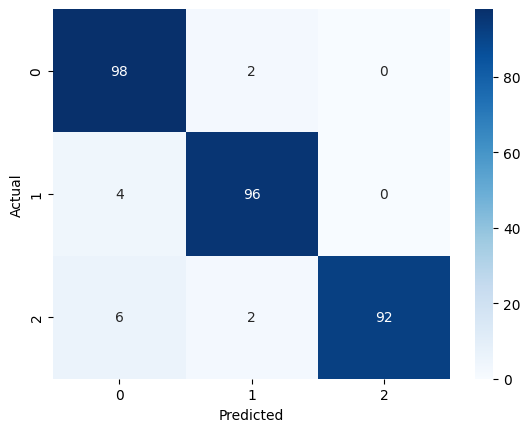

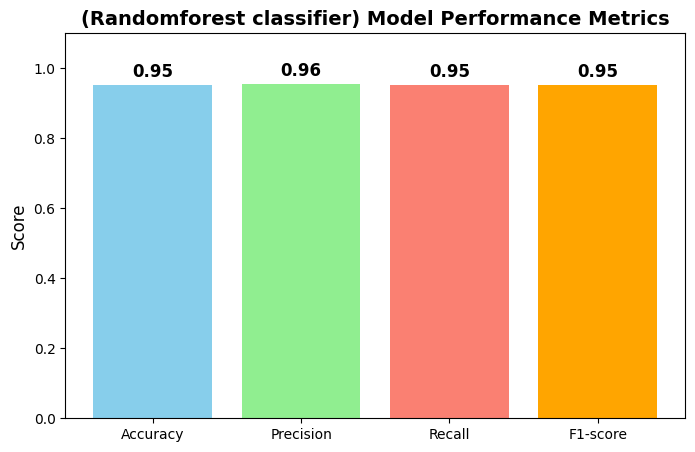

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = r_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(Randomforest classifier) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **BERT + Lightgbm**

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

clf_lgb =LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)


clf_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 768
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

LGBMClassifier(learning_rate=0.05, n_estimators=500, random_state=42)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.9466666666666667
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       100
           1       0.94      0.94      0.94       100
           2       1.00      0.93      0.96       100

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



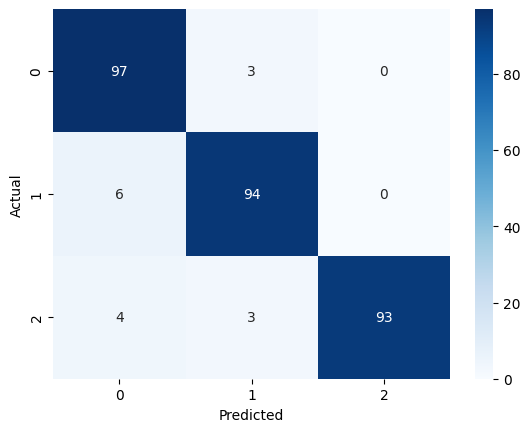

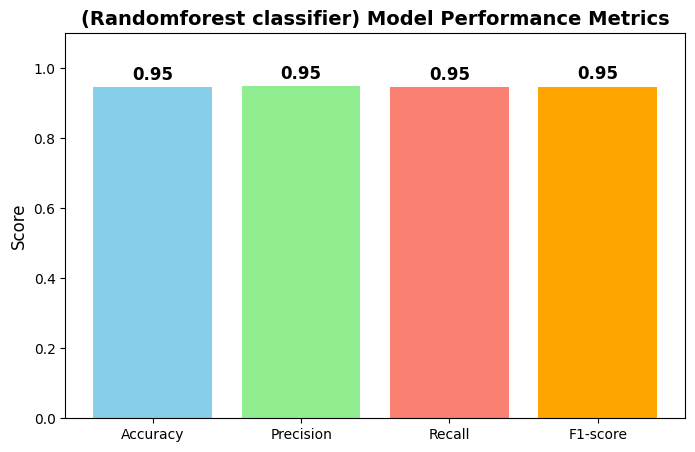

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


y_pred = clf_lgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(Randomforest classifier) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **SBERT + LSTM**

In [ ]:
df["text"].head(4)

0    i am year old junior in college i have multipl...
1    Remember when your mom said eating all that ju...
2    wish days could go emotional void turn numb li...
3    so i started having suicidal thought in april ...
Name: text, dtype: object

In [ ]:
!pip uninstall sentence-transformers transformers huggingface_hub -y


Found existing installation: sentence-transformers 2.2.2
Uninstalling sentence-transformers-2.2.2:
  Successfully uninstalled sentence-transformers-2.2.2
Found existing installation: transformers 4.57.0
Uninstalling transformers-4.57.0:
  Successfully uninstalled transformers-4.57.0
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3


In [ ]:
!pip uninstall -y transformers sentence-transformers huggingface_hub


In [ ]:
!pip install huggingface_hub==0.16.4
!pip install transformers==4.33.1
!pip install sentence-transformers==2.2.2



  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.35.3
    Uninstalling huggingface-hub-0.35.3:
      Successfully uninstalled huggingface-hub-0.35.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.57.0 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 0.16.4 which is incompatible.
datasets 4.0.0 requires huggingface-hub>=0.24.0, but you have huggingface-hub 0.16.4 which is incompatible.
gradio 5.49.0 requires huggingface-hub<2.0,>=0.33.5, but you have huggingface-hub 0.16.4 which is incompatible.
gradio-client 1.13.3 requires huggingface-hub<2.0,>=0.19.3, but you have huggingface-hub 0.16.4 which is incompatible.
peft 0.17.1 requires huggingface_hub>=0.25.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade sentence-transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.2
    Uninstalling sentence-transformers-2.2.2:
      Successfully uninstalled sentence-transformers-2.2.2


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
print("SBERT loaded successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SBERT loaded successfully!


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16,
                                show_progress_bar=True)

X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = y_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

inputs = Input(shape=(X.shape[1], X.shape[2]))
x = LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=16,
    callbacks=[early_stop],
    verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 279,555 (1.07 MB)

 Trainable params: 279,555 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.3737 - loss: 1.1515 - val_accuracy: 0.6022 - val_loss: 1.1343
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5609 - loss: 1.1291 - val_accuracy: 0.6600 - val_loss: 1.1052
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6395 - loss: 1.1003 - val_accuracy: 0.6867 - val_loss: 1.0593
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6816 - loss: 1.0516 - val_accuracy: 0.7244 - val_loss: 0.9886
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6877 - loss: 0.9829 - val_accuracy: 0.7533 - val_loss: 0.9004
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7078 - loss: 0.8989 - val_accuracy: 0.7822 - val_loss: 0.8132
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7271 - loss: 0.8154 - val_accuracy: 0.7911 - val_loss: 0.7418
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7427 - loss: 0.7409 - val_accuracy: 0.8222 - v

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


<Figure size 600x600 with 0 Axes>

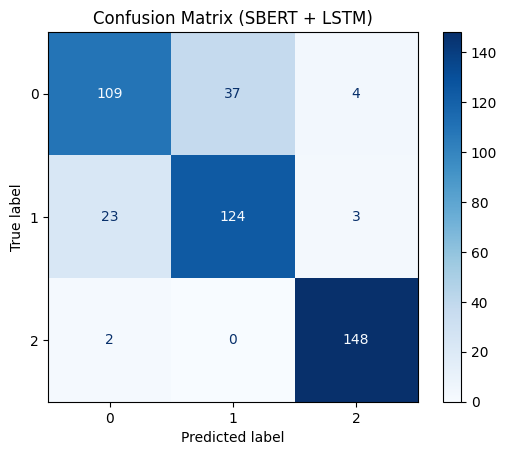

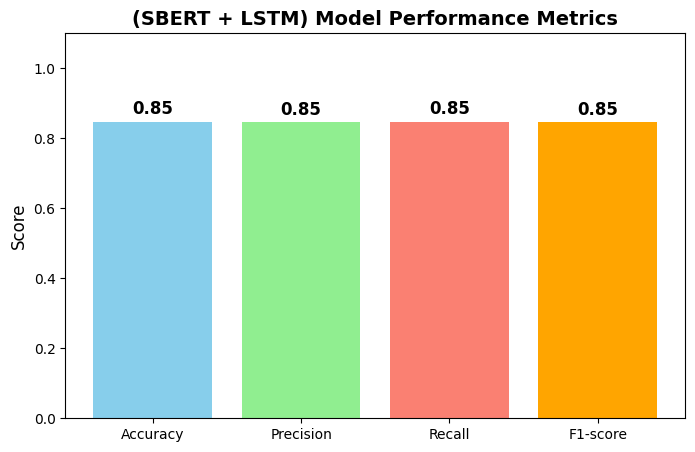

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(X_test, batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + LSTM)")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(SBERT + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


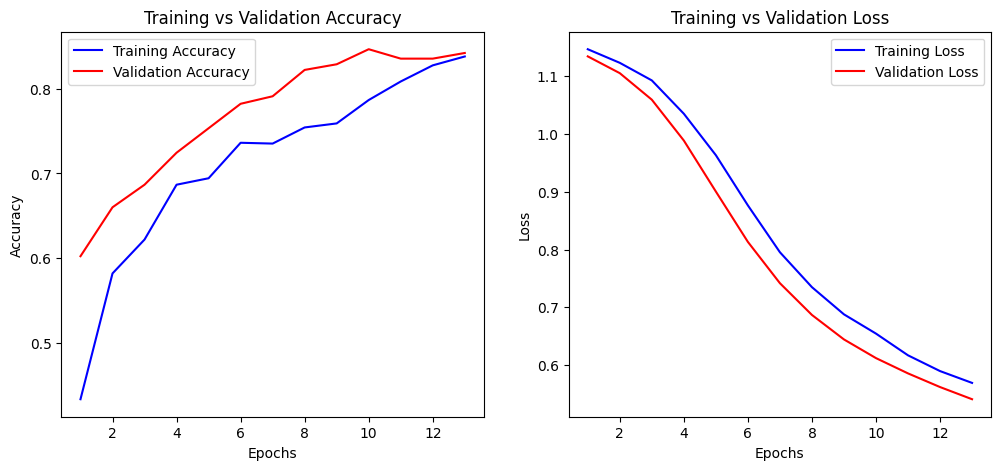

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **SBERT + BILSTM**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16,
                                show_progress_bar=True)

X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = y_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

inputs = Input(shape=(X.shape[1], X.shape[2]))
x = Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)))(inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=16,
    callbacks=[early_stop],
    verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       229,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,787 (964.01 KB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.4354 - loss: 1.1666 - val_accuracy: 0.6178 - val_loss: 1.1498
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5473 - loss: 1.1459 - val_accuracy: 0.6556 - val_loss: 1.1217
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6000 - loss: 1.1190 - val_accuracy: 0.6956 - val_loss: 1.0820
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6512 - loss: 1.0811 - val_accuracy: 0.7044 - val_loss: 1.0240
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6924 - loss: 1.0190 - val_accuracy: 0.7289 - val_loss: 0.9472
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7096 - loss: 0.9497 - val_accuracy: 0.7622 - val_loss: 0.8641
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7450 - loss: 0.8692 - val_accuracy: 0.7956 - val_loss: 0.7900
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7893 - loss: 0.8015 - val_accuracy: 0.8222 - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step


<Figure size 600x600 with 0 Axes>

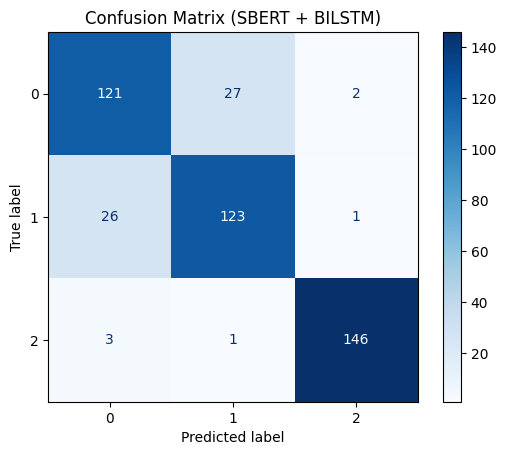

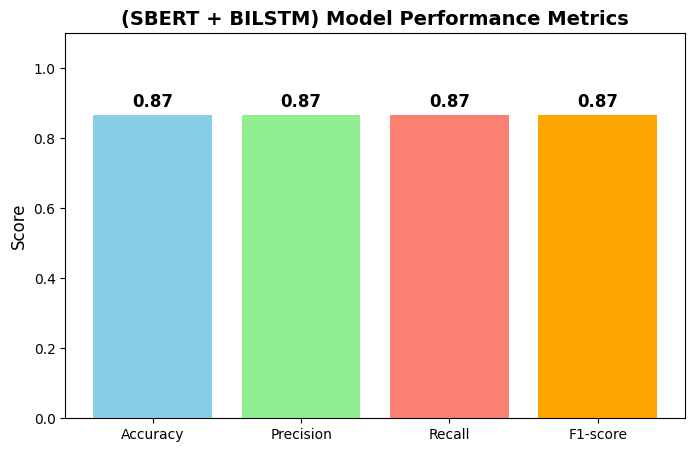

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(X_test, batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + BILSTM)")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(SBERT + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


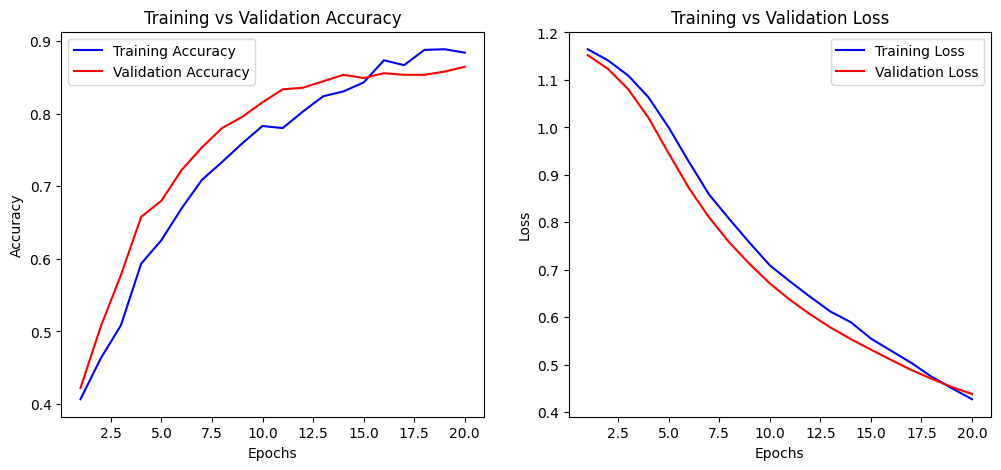

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **SBERT + GRU**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16,
                                show_progress_bar=True)

X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = y_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

inputs = Input(shape=(X.shape[1], X.shape[2]))
x = GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=16,
    callbacks=[early_stop],
    verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,107 (371.51 KB)

 Trainable params: 95,107 (371.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4038 - loss: 1.1273 - val_accuracy: 0.5578 - val_loss: 1.1158
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4968 - loss: 1.1121 - val_accuracy: 0.6733 - val_loss: 1.0951
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5842 - loss: 1.0947 - val_accuracy: 0.7267 - val_loss: 1.0639
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6304 - loss: 1.0607 - val_accuracy: 0.7467 - val_loss: 1.0169
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7126 - loss: 1.0127 - val_accuracy: 0.7489 - val_loss: 0.9524
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7127 - loss: 0.9491 - val_accuracy: 0.7689 - val_loss: 0.8767
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7253 - loss: 0.8896 - val_accuracy: 0.7911 - val_loss: 0.8009
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7571 - loss: 0.8074 - val_accuracy: 0.8000 - val_loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


<Figure size 600x600 with 0 Axes>

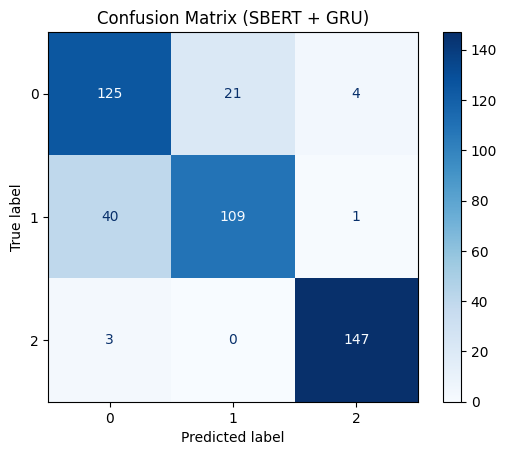

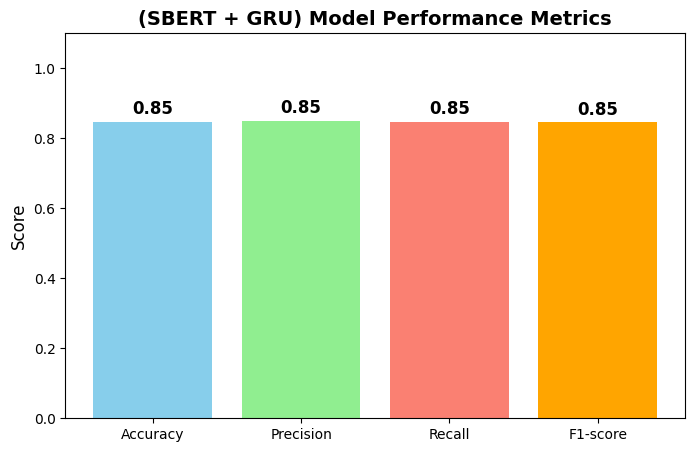

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(X_test, batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + GRU)")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(SBERT + GRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


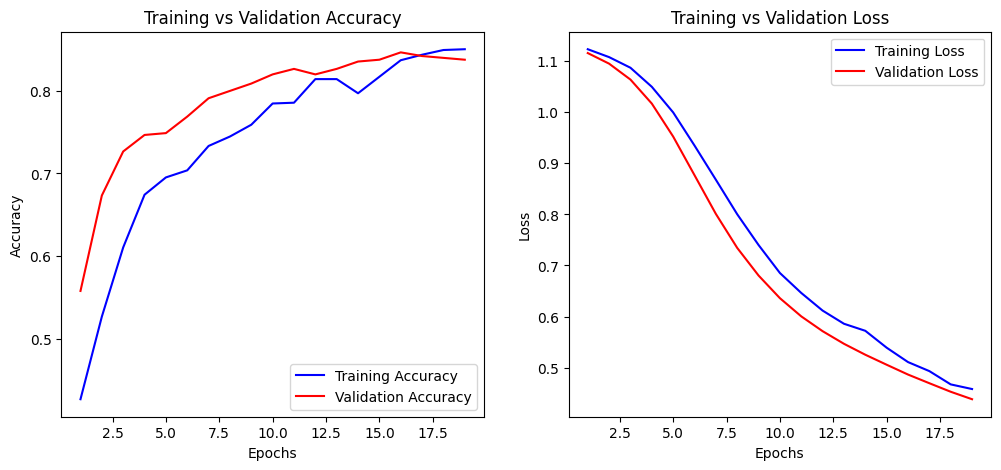

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **SBERT + BIGRU**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16,
                                show_progress_bar=True)

X = embeddings.reshape((embeddings.shape[0], 1, embeddings.shape[1]))
y = y_cleaned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

inputs = Input(shape=(X.shape[1], X.shape[2]))
x = Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)))(inputs)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=16,
    callbacks=[early_stop],
    verbose=1)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │       172,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,699 (741.01 KB)

 Trainable params: 189,699 (741.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3398 - loss: 1.1607 - val_accuracy: 0.6222 - val_loss: 1.1311
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5557 - loss: 1.1250 - val_accuracy: 0.6978 - val_loss: 1.0913
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6272 - loss: 1.0862 - val_accuracy: 0.7178 - val_loss: 1.0372
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6783 - loss: 1.0282 - val_accuracy: 0.7556 - val_loss: 0.9664
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6858 - loss: 0.9677 - val_accuracy: 0.7756 - val_loss: 0.8838
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7335 - loss: 0.8946 - val_accuracy: 0.8044 - val_loss: 0.8013
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7575 - loss: 0.8160 - val_accuracy: 0.8200 - val_loss: 0.7271
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7768 - loss: 0.7328 - val_accuracy: 0.8289 - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Figure size 600x600 with 0 Axes>

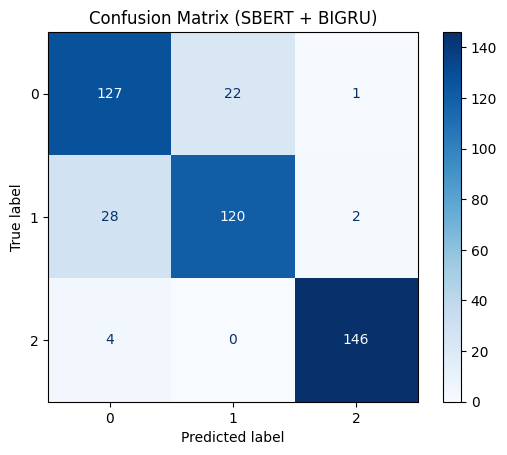

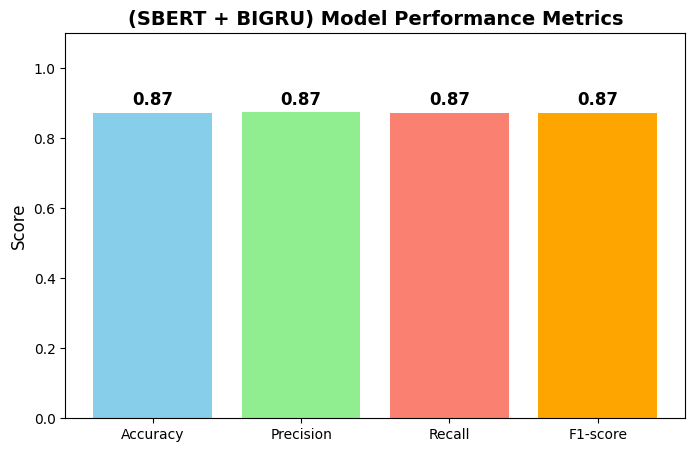

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


y_pred_prob = model.predict(X_test, batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + BIGRU)")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])

for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")

plt.ylim(0,1.1)
plt.title("(SBERT + BIGRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


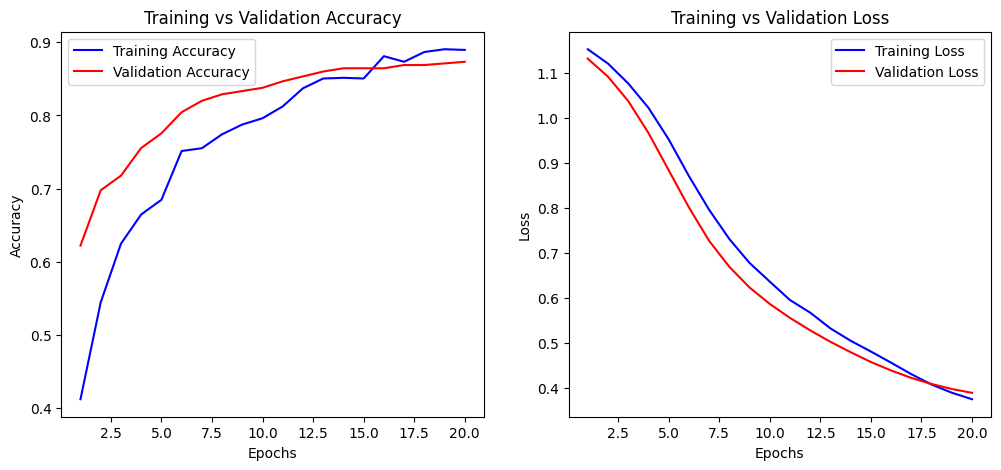

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **SBERT + Logistic regression**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16, show_progress_bar=True)

X = embeddings  # keep 2D
y = np.array(y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)



Batches:   0%|          | 0/94 [00:00<?, ?it/s]

LogisticRegression(max_iter=2000)

<Figure size 600x600 with 0 Axes>

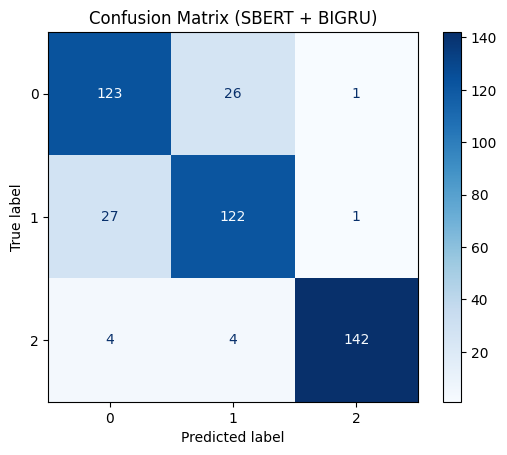

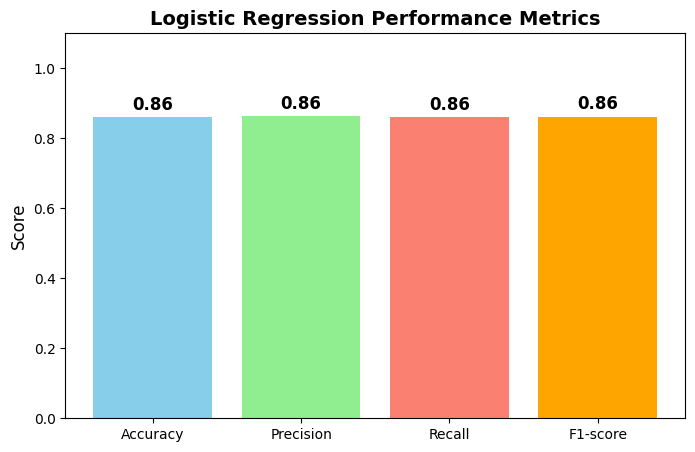

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + BIGRU)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Logistic Regression Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **SBERT + xgboost**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16, show_progress_bar=True)

X = embeddings  # keep 2D
y = np.array(y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("[INFO] Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)







Batches:   0%|          | 0/94 [00:00<?, ?it/s]

[INFO] Training XGBoost classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:49:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

<Figure size 600x600 with 0 Axes>

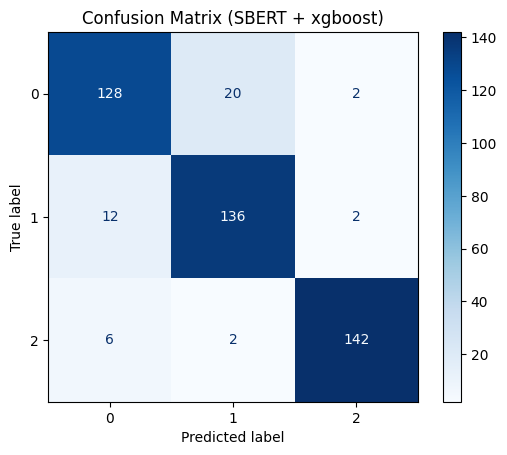

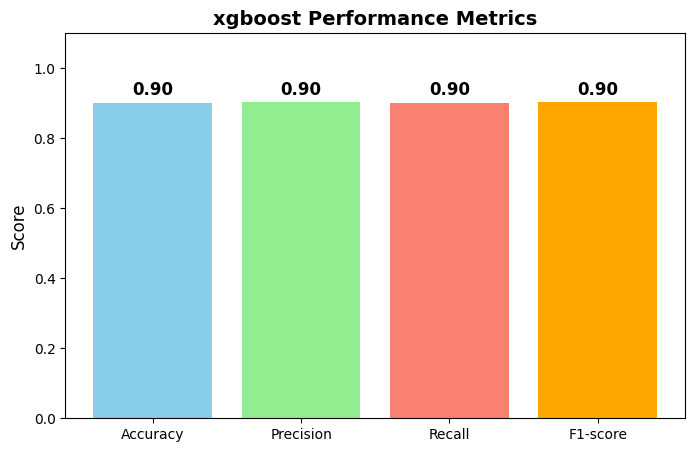

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + xgboost)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("xgboost Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **sbert + Randomforest classifier**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16, show_progress_bar=True)

X = embeddings  # keep 2D
y = np.array(y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("[INFO] Training Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=300,       # number of trees
    max_depth=20,           # limit depth to avoid overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)











Batches:   0%|          | 0/94 [00:00<?, ?it/s]

[INFO] Training Random Forest classifier...


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

<Figure size 600x600 with 0 Axes>

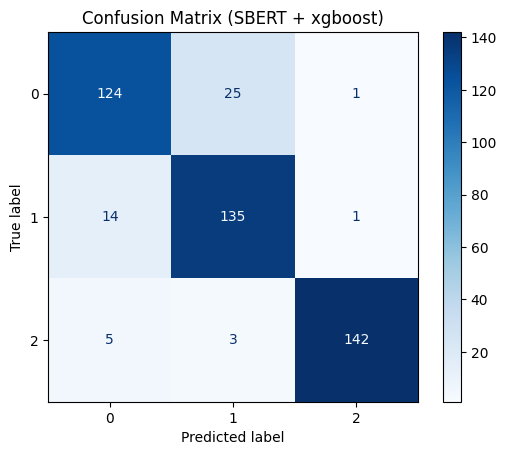

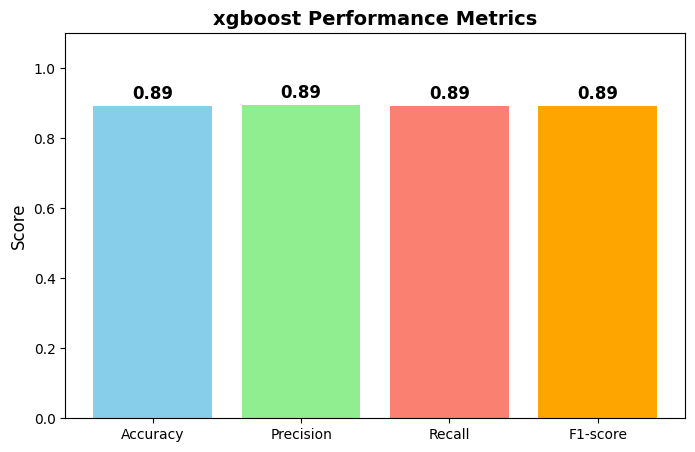

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + xgboost)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("xgboost Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **SBERT + SVM**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = sbert_model.encode(X_cleaned, batch_size=16, show_progress_bar=True)

X = embeddings
y = np.array(y_cleaned)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("[INFO] Training SVM classifier...")
svm_model = SVC(
    kernel='rbf',       # radial basis function kernel
    C=10.0,             # regularization parameter
    gamma='scale',      # kernel coefficient
    probability=True,   # needed if you want predict_proba
    random_state=42
)

svm_model.fit(X_train, y_train)



Batches:   0%|          | 0/94 [00:00<?, ?it/s]

[INFO] Training SVM classifier...


SVC(C=10.0, probability=True, random_state=42)

<Figure size 600x600 with 0 Axes>

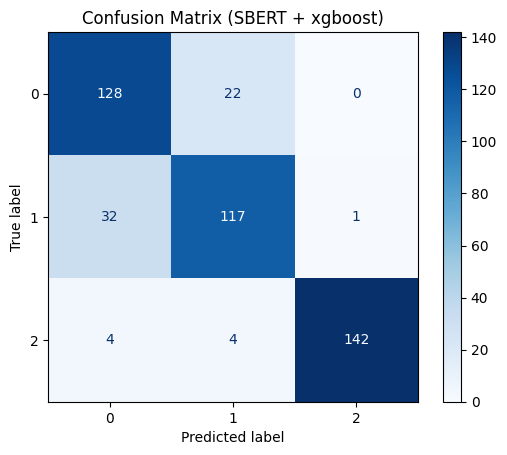

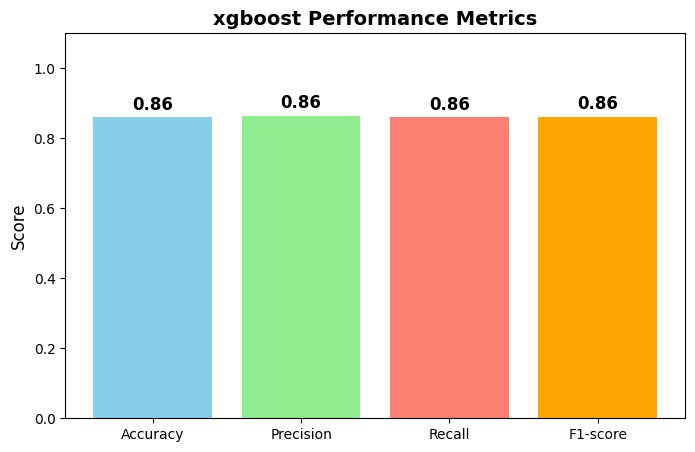

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (SBERT + xgboost)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("xgboost Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()

# **DistilBert + LSTM**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False

encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # shape: (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")


bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])

x = LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


model.summary()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1014s 13s/step - accuracy: 0.3675 - loss: 1.1611 - val_accuracy: 0.6733 - val_loss: 0.9666
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1009s 13s/step - accuracy: 0.5247 - loss: 1.0045 - val_accuracy: 0.8333 - val_loss: 0.7491
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 958s 13s/step - accuracy: 0.6668 - loss: 0.7910 - val_accuracy: 0.8533 - val_loss: 0.5621
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 983s 13s/step - accuracy: 0.7863 - loss: 0.6005 - val_accuracy: 0.8933 - val_loss: 0.4159
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 995s 13s/step - accuracy: 0.8501 - loss: 0.4771 - val_accuracy: 0.9167 - val_loss: 0.3077
Test Accuracy: 0.9167


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_embedd… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (DistilBertEmbeddi… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │    213,248 │ distil_bert_embe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ lstm_5[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │      8,320 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 3)         │        387 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 665,867 (2.54 MB)

 Trainable params: 221,955 (867.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 443,912 (1.69 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 209s 13s/step


<Figure size 600x600 with 0 Axes>

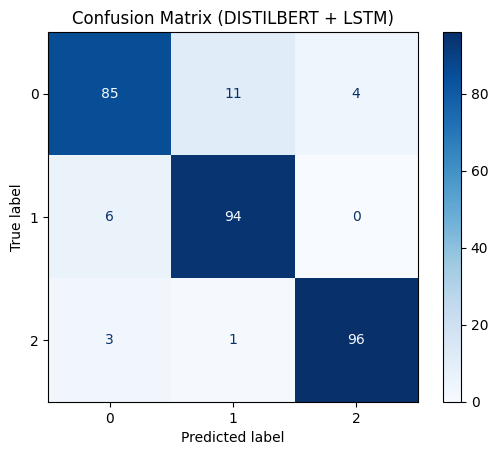

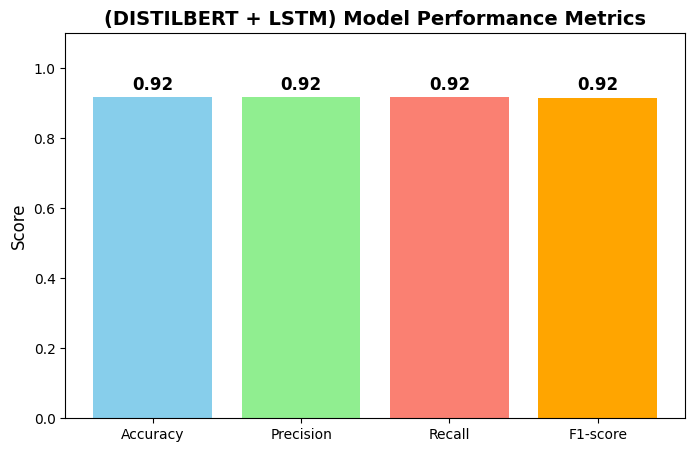

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (DISTILBERT + LSTM)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(DISTILBERT + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


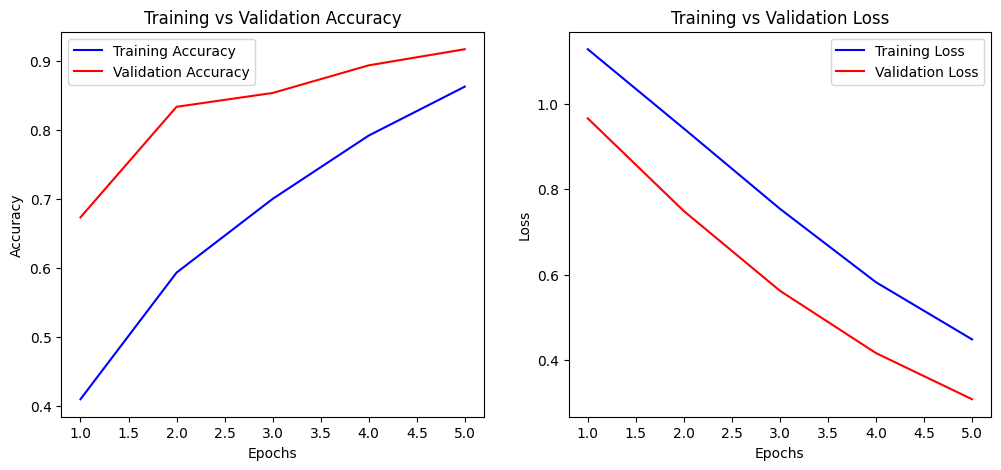

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **DISTILBERT + BILSTM**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False

encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # shape: (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")


bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])

x = Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(3e-5)))(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


model.summary()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 969s 13s/step - accuracy: 0.3966 - loss: 1.1683 - val_accuracy: 0.8600 - val_loss: 0.8398
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 970s 13s/step - accuracy: 0.6251 - loss: 0.8797 - val_accuracy: 0.8833 - val_loss: 0.5885
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 951s 13s/step - accuracy: 0.7797 - loss: 0.6541 - val_accuracy: 0.9067 - val_loss: 0.4014
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1005s 13s/step - accuracy: 0.8289 - loss: 0.5149 - val_accuracy: 0.9267 - val_loss: 0.2792
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 968s 13s/step - accuracy: 0.9157 - loss: 0.3488 - val_accuracy: 0.9267 - val_loss: 0.2326
Test Accuracy: 0.9267


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_embedd… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (DistilBertEmbeddi… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    426,496 │ distil_bert_embe… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,330,187 (5.07 MB)

 Trainable params: 443,395 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 886,792 (3.38 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 211s 13s/step


<Figure size 600x600 with 0 Axes>

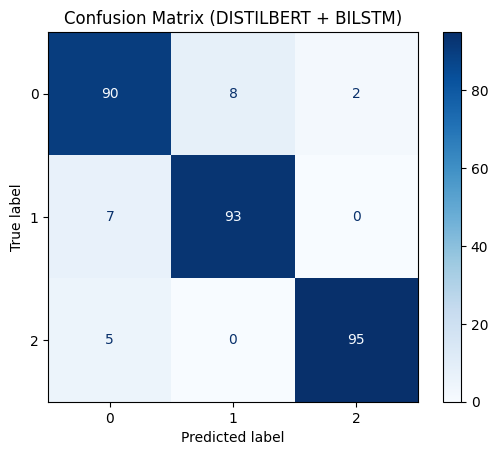

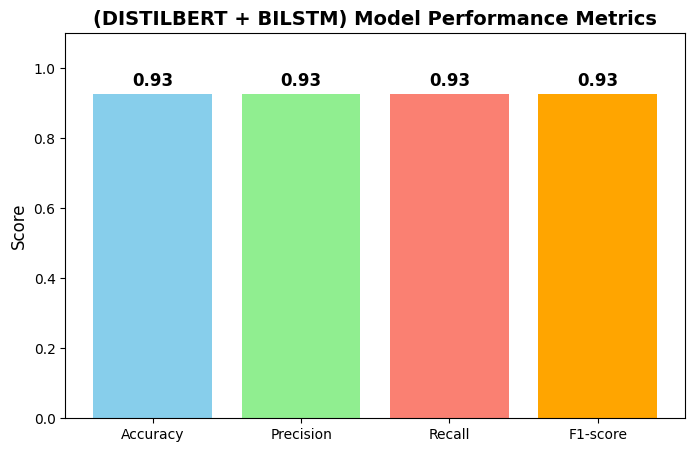

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (DISTILBERT + BILSTM)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(DISTILBERT + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


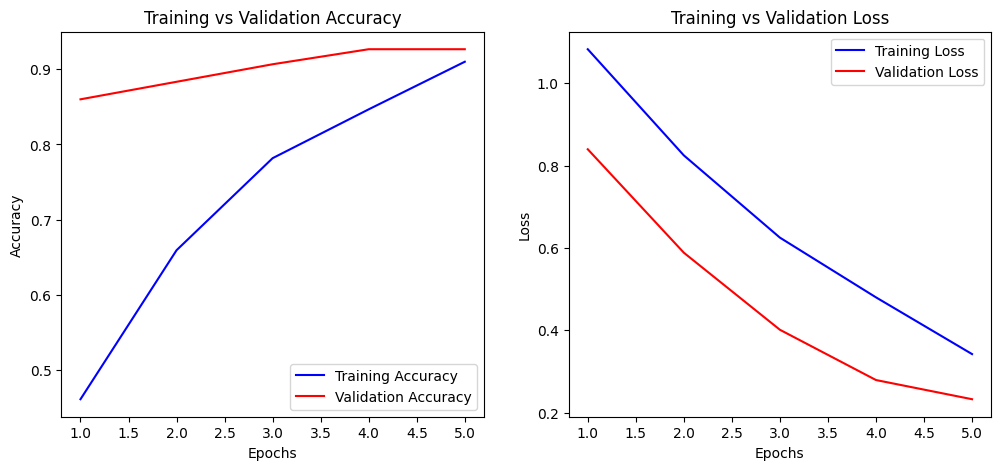

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **DISTILBERT + GRU**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False

encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # shape: (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")


bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])

x = GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 944s 13s/step - accuracy: 0.3624 - loss: 1.2061 - val_accuracy: 0.7867 - val_loss: 0.9682
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 931s 12s/step - accuracy: 0.5299 - loss: 1.0215 - val_accuracy: 0.8467 - val_loss: 0.8185
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1005s 13s/step - accuracy: 0.6263 - loss: 0.8991 - val_accuracy: 0.9133 - val_loss: 0.6677
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 934s 12s/step - accuracy: 0.7373 - loss: 0.7520 - val_accuracy: 0.9233 - val_loss: 0.5284
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1005s 13s/step - accuracy: 0.7924 - loss: 0.6459 - val_accuracy: 0.9233 - val_loss: 0.4150
Test Accuracy: 0.9233


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_embedd… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (DistilBertEmbeddi… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │    160,128 │ distil_bert_embe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        387 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 506,507 (1.93 MB)

 Trainable params: 168,835 (659.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 337,672 (1.29 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 217s 14s/step


<Figure size 600x600 with 0 Axes>

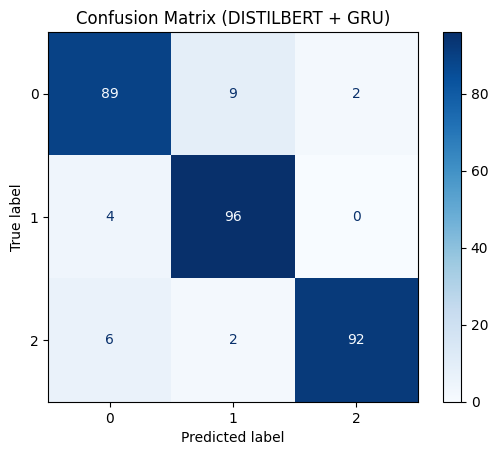

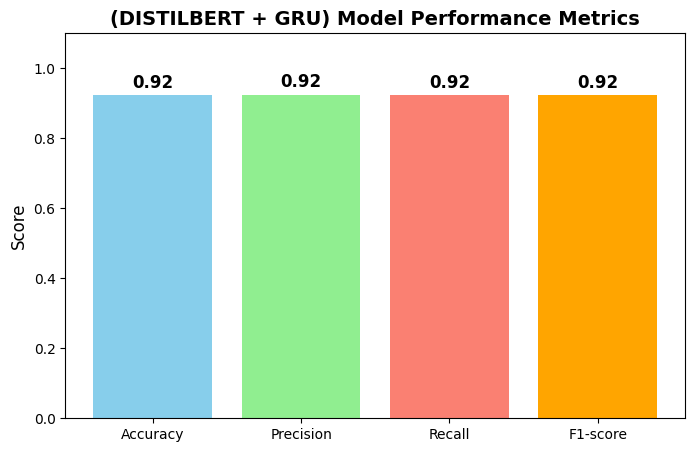

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (DISTILBERT + GRU)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(DISTILBERT + GRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


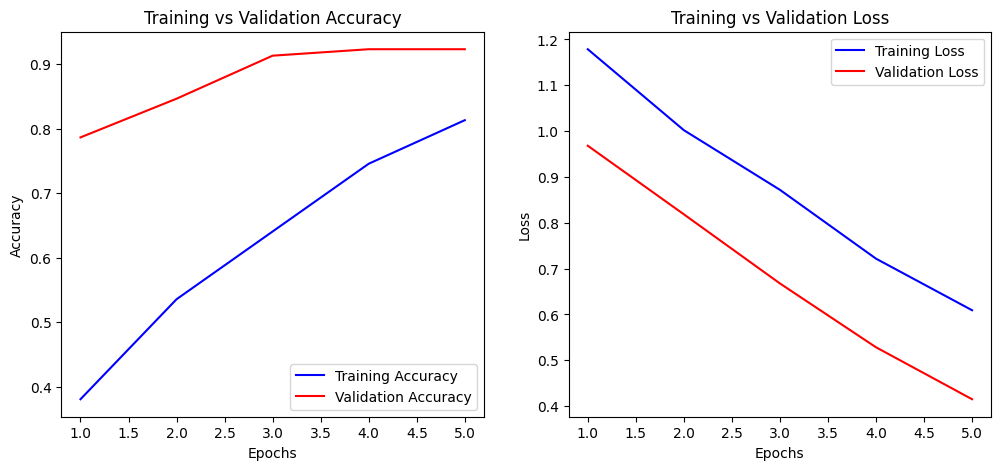

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **DISTILBERT + BIGRU**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False

encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class DistilBertEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, distilbert_model, **kwargs):
        super().__init__(**kwargs)
        self.distilbert = distilbert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.distilbert(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # shape: (batch, seq_len, 768)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")


bert_embeddings = DistilBertEmbeddingLayer(distilbert)([input_ids_layer, attention_mask_layer])

x = Bidirectional(
        GRU(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))
    )(bert_embeddings)
x = Dropout(0.6)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.6)(x)
outputs = Dense(num_classes, activation="softmax")(x)  # Softmax for multi-class


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)


loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


model.summary()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the mode

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 940s 12s/step - accuracy: 0.4011 - loss: 1.2368 - val_accuracy: 0.8833 - val_loss: 0.8313
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 922s 12s/step - accuracy: 0.6197 - loss: 0.9292 - val_accuracy: 0.9200 - val_loss: 0.6025
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 948s 13s/step - accuracy: 0.7392 - loss: 0.7474 - val_accuracy: 0.9267 - val_loss: 0.4610
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 923s 12s/step - accuracy: 0.8037 - loss: 0.5979 - val_accuracy: 0.9267 - val_loss: 0.3709
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 982s 12s/step - accuracy: 0.8652 - loss: 0.5056 - val_accuracy: 0.9167 - val_loss: 0.3301
Test Accuracy: 0.9267


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_embedd… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (DistilBertEmbeddi… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    689,664 │ distil_bert_embe… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,118,923 (8.08 MB)

 Trainable params: 706,307 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,412,616 (5.39 MB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 200s 12s/step


<Figure size 600x600 with 0 Axes>

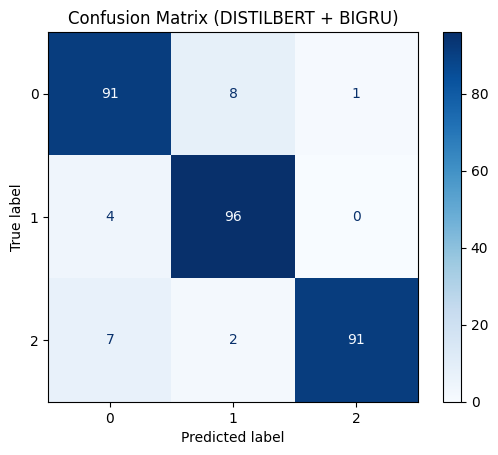

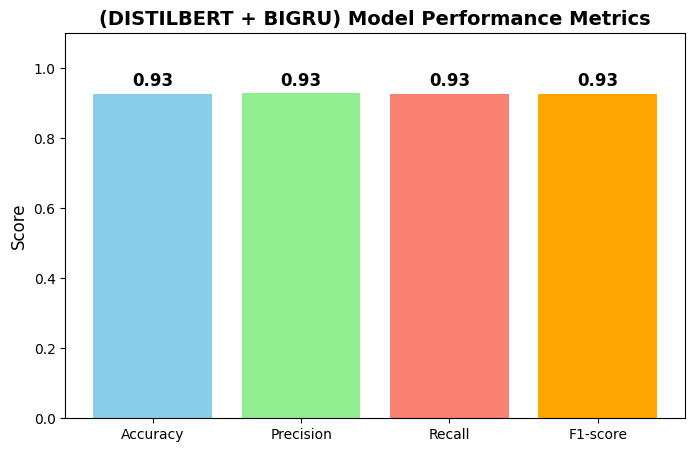

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (DISTILBERT + BIGRU)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(DISTILBERT + BIGRU) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


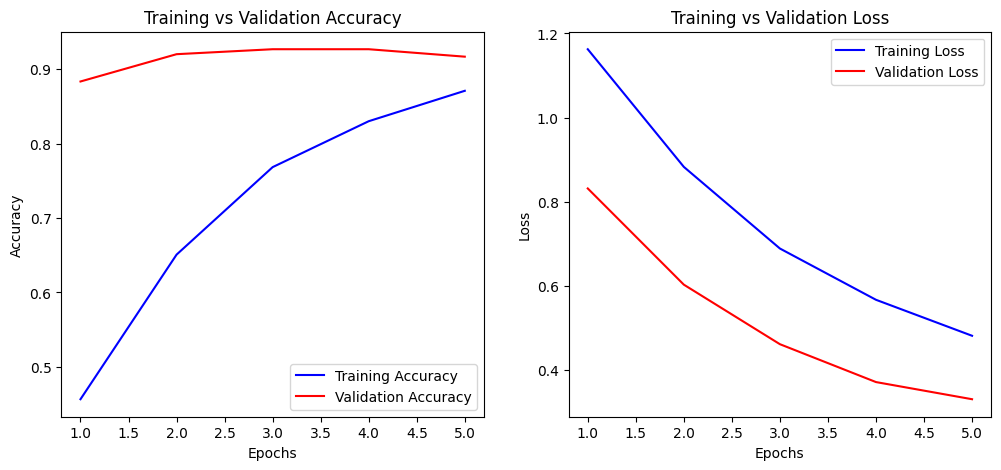

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **DISTILBERT + Logistic regression**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

MAX_LEN = 256
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


embeddings_list = []
for i in tqdm(range(0, len(input_ids), BATCH_SIZE)):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeds = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()  # mean pooling
    embeddings_list.append(batch_embeds)

embeddings = np.concatenate(embeddings_list, axis=0)


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, stratify=y, random_state=42
)


clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel f

Accuracy: 0.9466666666666667


<Figure size 600x600 with 0 Axes>

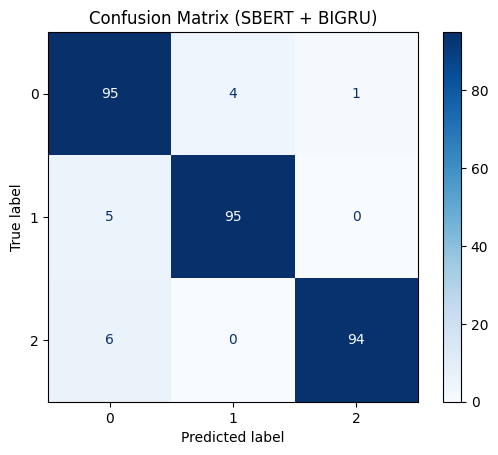

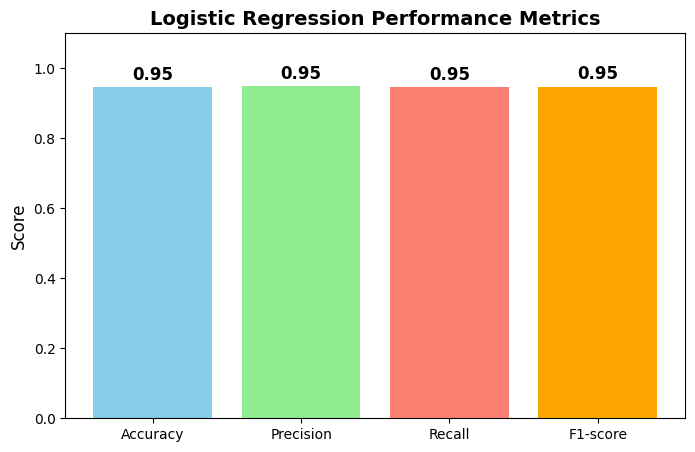

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (distilBERT + logistic regression)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Logistic Regression Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT + XGBOOST**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from tqdm import tqdm

MAX_LEN = 256
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


embeddings_list = []
for i in tqdm(range(0, len(input_ids), BATCH_SIZE)):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeds = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()  # mean pooling
    embeddings_list.append(batch_embeds)

embeddings = np.concatenate(embeddings_list, axis=0)


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
100%|██████████| 94/94 [19:13<00:00, 12.27s/it]


[INFO] Training XGBoost classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:08:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

<Figure size 600x600 with 0 Axes>

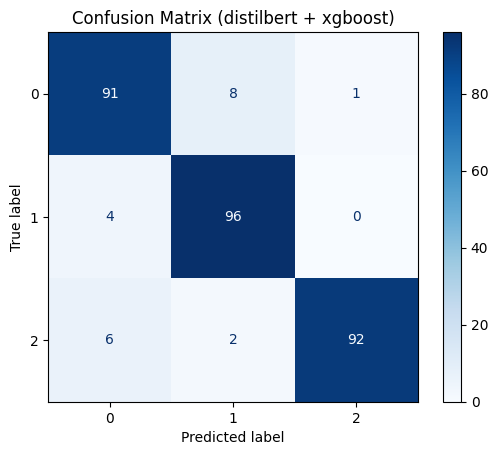

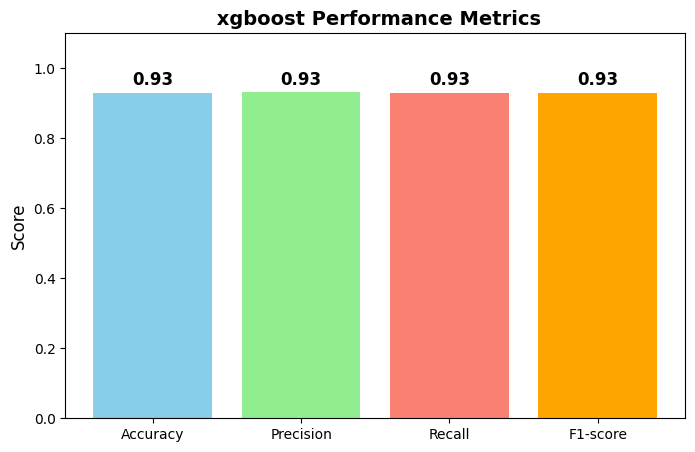

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (distilbert + xgboost)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title(" xgboost Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT + RANDOMFOREST**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier

MAX_LEN = 256
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


embeddings_list = []
for i in tqdm(range(0, len(input_ids), BATCH_SIZE)):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeds = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()  # mean pooling
    embeddings_list.append(batch_embeds)

embeddings = np.concatenate(embeddings_list, axis=0)


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=300,       # number of trees
    max_depth=20,           # limit depth to avoid overfitting
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
100%|██████████| 94/94 [17:18<00:00, 11.05s/it]


[INFO] Training Random Forest classifier...


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=300, n_jobs=-1, random_state=42)

<Figure size 600x600 with 0 Axes>

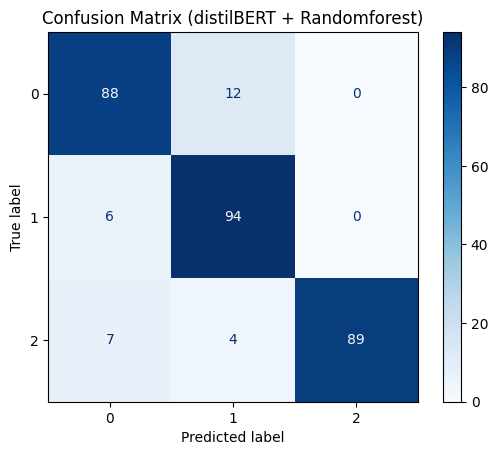

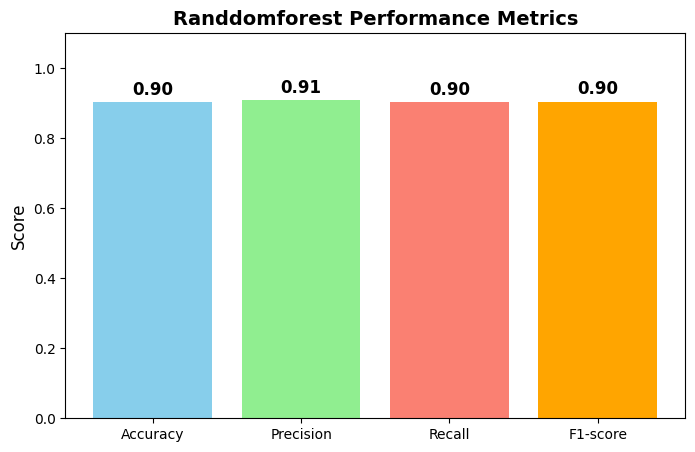

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (distilBERT + Randomforest)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Randdomforest Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **DISTILBERT + SVM**

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC

MAX_LEN = 256
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
distilbert = TFDistilBertModel.from_pretrained("distilbert-base-uncased", from_pt=True)
distilbert.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


embeddings_list = []
for i in tqdm(range(0, len(input_ids), BATCH_SIZE)):
    batch_input_ids = input_ids[i:i+BATCH_SIZE]
    batch_attention_mask = attention_mask[i:i+BATCH_SIZE]
    outputs = distilbert(batch_input_ids, attention_mask=batch_attention_mask)
    batch_embeds = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()  # mean pooling
    embeddings_list.append(batch_embeds)

embeddings = np.concatenate(embeddings_list, axis=0)


X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training SVM classifier...")
svm_model = SVC(
    kernel='rbf',       # radial basis function kernel
    C=10.0,             # regularization parameter
    gamma='scale',      # kernel coefficient
    probability=True,   # needed if you want predict_proba
    random_state=42
)

svm_model.fit(X_train, y_train)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
100%|██████████| 94/94 [17:36<00:00, 11.24s/it]


[INFO] Training SVM classifier...


SVC(C=10.0, probability=True, random_state=42)

<Figure size 600x600 with 0 Axes>

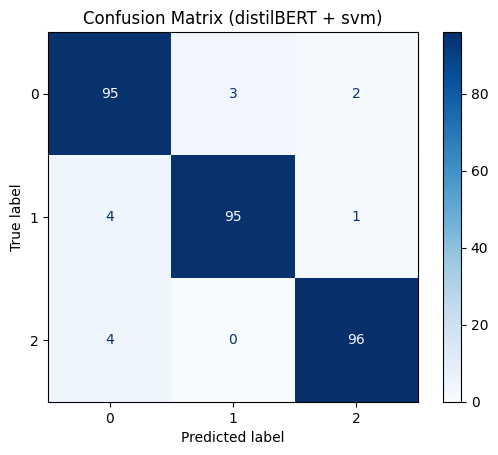

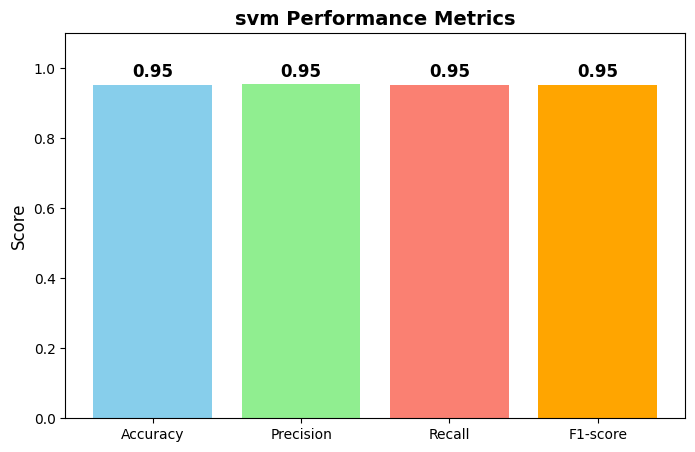

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = svm_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (distilBERT + svm)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("svm Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **Roberta + Lstm**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


roberta_model.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, hidden_size)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

roberta_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(roberta_embeddings)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation="softmax")(x)


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"\n Test Accuracy: {acc:.4f}")




[INFO] Loading RoBERTa...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roberta_embedding_… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (RobertaEmbeddingL… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    459,264 │ roberta_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 467,715 (1.78 MB)

 Trainable params: 467,715 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1880s 25s/step - accuracy: 0.4046 - loss: 1.1585 - val_accuracy: 0.8733 - val_loss: 0.7596
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1780s 24s/step - accuracy: 0.7442 - loss: 0.7851 - val_accuracy: 0.8767 - val_loss: 0.4385
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1804s 24s/step - accuracy: 0.8593 - loss: 0.4860 - val_accuracy: 0.8967 - val_loss: 0.3920
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1787s 24s/step - accuracy: 0.9063 - loss: 0.3624 - val_accuracy: 0.8933 - val_loss: 0.3827
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1849s 24s/step - accuracy: 0.9194 - loss: 0.3521 - val_accuracy: 0.9233 - val_loss: 0.3105

 Test Accuracy: 0.9233


15/15 ━━━━━━━━━━━━━━━━━━━━ 361s 24s/step


<Figure size 600x600 with 0 Axes>

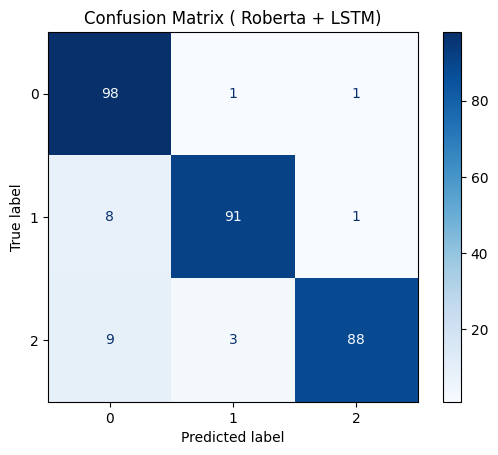

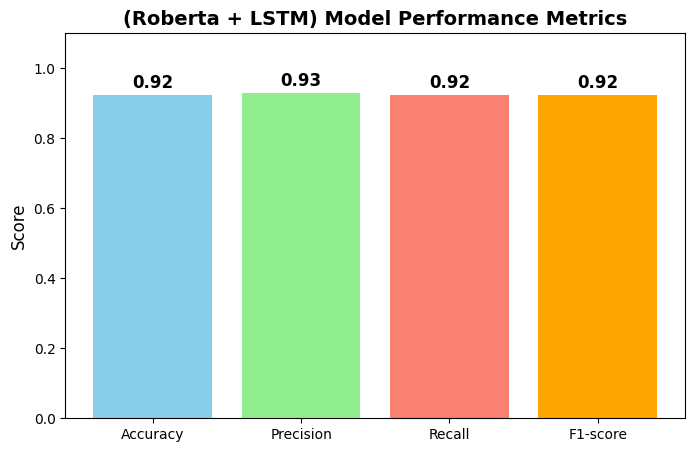

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix ( Roberta + LSTM)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(Roberta + LSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **Roberta + BILSTM**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


roberta_model.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, hidden_size)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

roberta_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = Bidirectional(
    LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(3e-5))
)(roberta_embeddings)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation="softmax")(x)


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"\n Test Accuracy: {acc:.4f}")




[INFO] Loading RoBERTa...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roberta_embedding_… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (RobertaEmbeddingL… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    426,496 │ roberta_embeddin… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 434,947 (1.66 MB)

 Trainable params: 434,947 (1.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1619s 21s/step - accuracy: 0.4092 - loss: 1.1325 - val_accuracy: 0.8900 - val_loss: 0.8048
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1600s 21s/step - accuracy: 0.7150 - loss: 0.8004 - val_accuracy: 0.8933 - val_loss: 0.4914
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1645s 21s/step - accuracy: 0.8324 - loss: 0.5692 - val_accuracy: 0.9167 - val_loss: 0.3228
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1609s 22s/step - accuracy: 0.8896 - loss: 0.3778 - val_accuracy: 0.9367 - val_loss: 0.2613
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1605s 21s/step - accuracy: 0.9342 - loss: 0.2766 - val_accuracy: 0.9533 - val_loss: 0.2050

 Test Accuracy: 0.9533


15/15 ━━━━━━━━━━━━━━━━━━━━ 428s 28s/step


<Figure size 600x600 with 0 Axes>

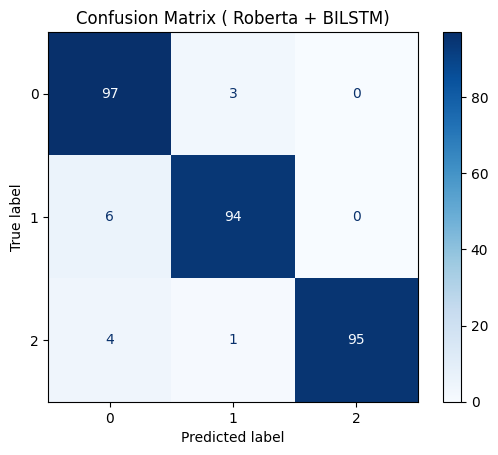

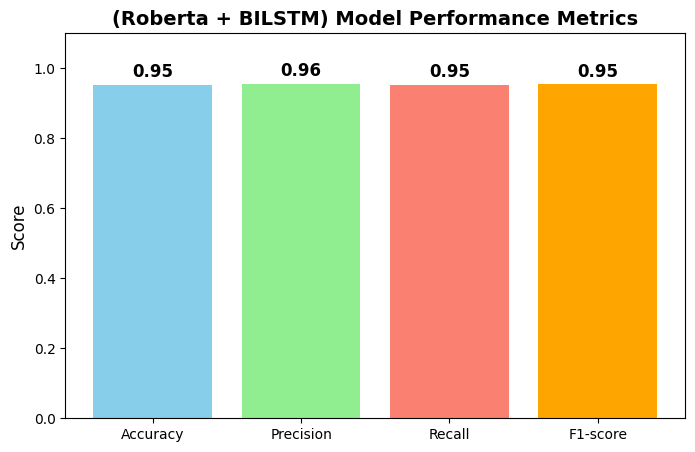

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix ( Roberta + BILSTM)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(Roberta + BILSTM) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


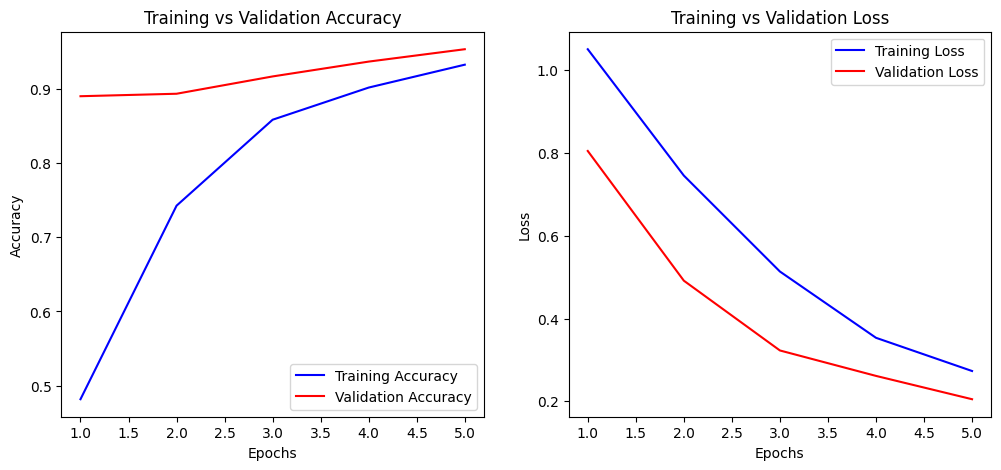

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Roberta + GRU**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


roberta_model.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, hidden_size)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

roberta_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))(roberta_embeddings)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation="softmax")(x)


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"\n Test Accuracy: {acc:.4f}")




[INFO] Loading RoBERTa...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roberta_embedding_… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (RobertaEmbeddingL… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │    160,128 │ roberta_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        195 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 164,483 (642.51 KB)

 Trainable params: 164,483 (642.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1613s 21s/step - accuracy: 0.3504 - loss: 1.3074 - val_accuracy: 0.7367 - val_loss: 0.9775
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1624s 21s/step - accuracy: 0.4962 - loss: 1.0407 - val_accuracy: 0.8333 - val_loss: 0.7949
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1650s 21s/step - accuracy: 0.6973 - loss: 0.8327 - val_accuracy: 0.8700 - val_loss: 0.6044
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1591s 21s/step - accuracy: 0.7402 - loss: 0.7122 - val_accuracy: 0.8567 - val_loss: 0.4871
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1645s 21s/step - accuracy: 0.8124 - loss: 0.5785 - val_accuracy: 0.8767 - val_loss: 0.4178

 Test Accuracy: 0.8767


15/15 ━━━━━━━━━━━━━━━━━━━━ 436s 27s/step


<Figure size 600x600 with 0 Axes>

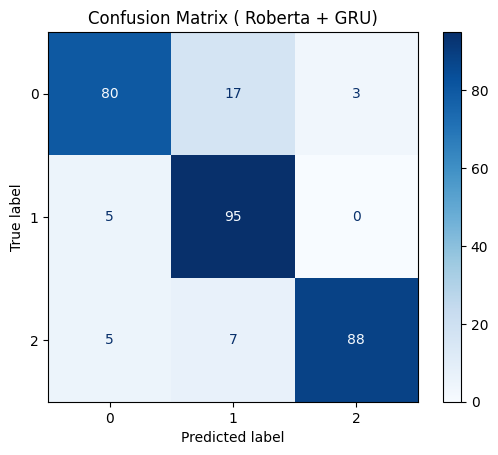

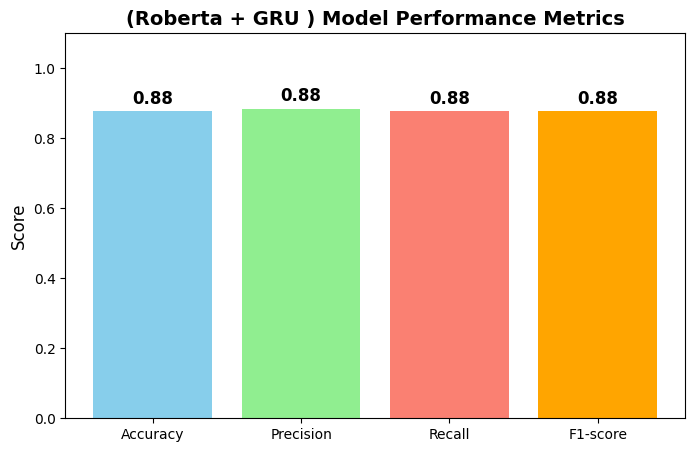

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix ( Roberta + GRU)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(Roberta + GRU ) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


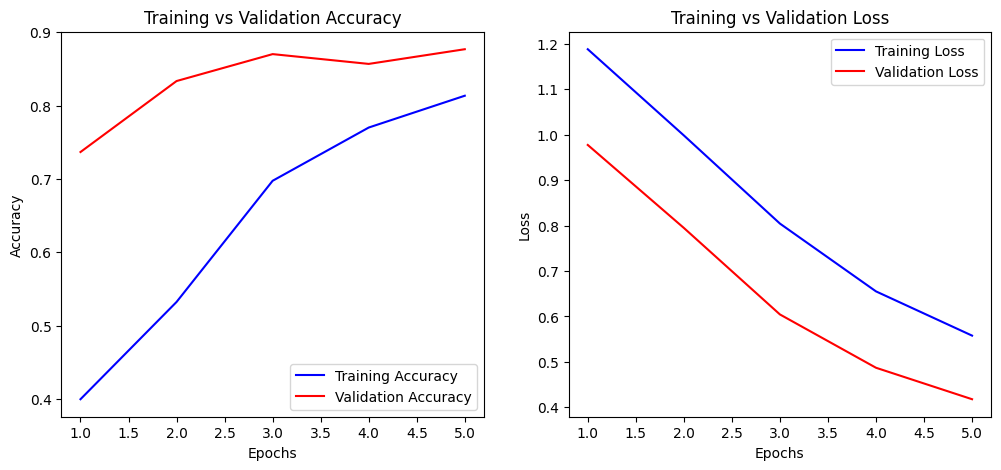

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Roberta + BIGRU**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder



MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 5
LR = 1e-4


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_raw)
num_classes = len(label_encoder.classes_)
y = np.array(y_cleaned)

print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


roberta_model.trainable = False


encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"].numpy()
attention_mask = encodings["attention_mask"].numpy()


X_train_ids, X_test_ids, X_train_mask, X_test_mask, y_train, y_test = train_test_split(
    input_ids, attention_mask, y, test_size=0.2, stratify=y, random_state=42
)


class RobertaEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, roberta_model, **kwargs):
        super().__init__(**kwargs)
        self.roberta = roberta_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # (batch, seq_len, hidden_size)


input_ids_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
attention_mask_layer = Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")

roberta_embeddings = RobertaEmbeddingLayer(roberta_model)([input_ids_layer, attention_mask_layer])


x = Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)))(roberta_embeddings)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation="softmax")(x)


model = Model(inputs=[input_ids_layer, attention_mask_layer], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)


history = model.fit(
    [X_train_ids, X_train_mask], y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate
loss, acc = model.evaluate([X_test_ids, X_test_mask], y_test, verbose=0)
print(f"\n Test Accuracy: {acc:.4f}")




[INFO] Loading RoBERTa...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roberta_embedding_… │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (RobertaEmbeddingL… │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    320,256 │ roberta_embeddin… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 328,707 (1.25 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1716s 23s/step - accuracy: 0.3523 - loss: 1.2338 - val_accuracy: 0.8800 - val_loss: 0.9357
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1627s 22s/step - accuracy: 0.5664 - loss: 0.9968 - val_accuracy: 0.9167 - val_loss: 0.7173
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1615s 22s/step - accuracy: 0.7330 - loss: 0.7782 - val_accuracy: 0.9400 - val_loss: 0.5168
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1635s 22s/step - accuracy: 0.8221 - loss: 0.5983 - val_accuracy: 0.9367 - val_loss: 0.3719
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 1633s 21s/step - accuracy: 0.8727 - loss: 0.4803 - val_accuracy: 0.9400 - val_loss: 0.2935

 Test Accuracy: 0.9400


15/15 ━━━━━━━━━━━━━━━━━━━━ 410s 26s/step


<Figure size 600x600 with 0 Axes>

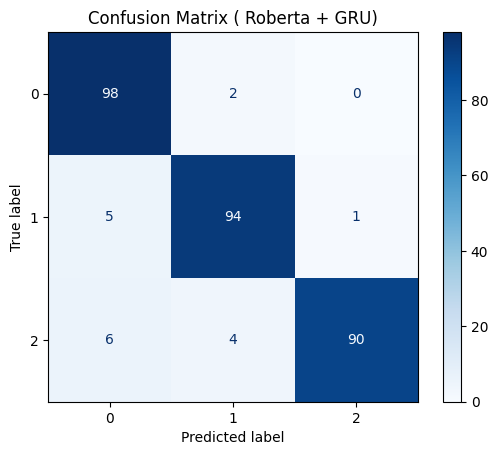

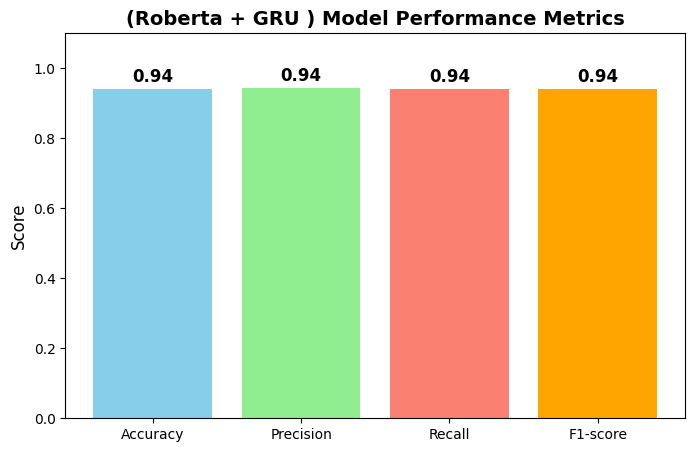

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred_prob = model.predict([X_test_ids, X_test_mask], batch_size=20)
y_pred = np.argmax(y_pred_prob, axis=1)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix ( Roberta + GRU)")
plt.show()


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("(Roberta + GRU ) Model Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


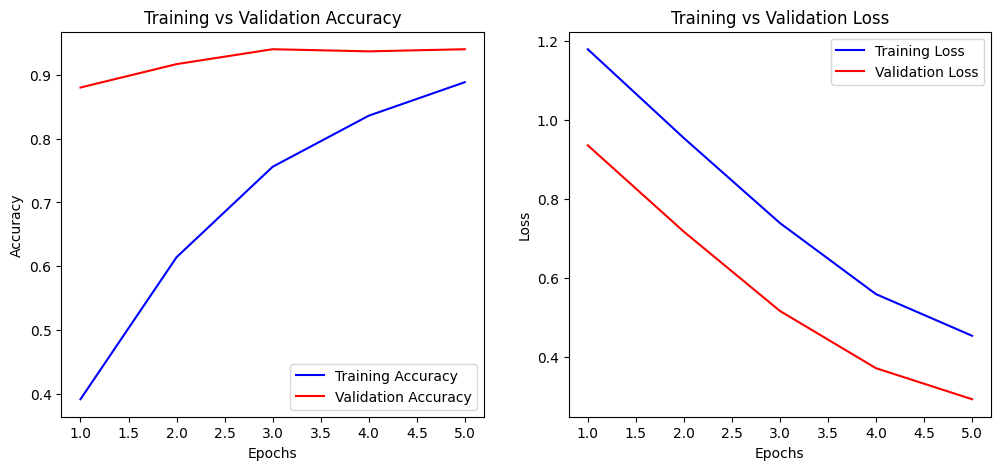

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))


plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
x = Bidirectional(
        GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4))
    )(bert_embeddings)

x = Bidirectional(GRU(64, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)))(roberta_embeddings)


# **Roberta + Logistc regression**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tqdm import tqdm

MAX_LEN = 256
BATCH_SIZE = 16


X_cleaned = df['text'].tolist()
y_raw = df['Category'].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


print("[INFO] Loading RoBERTa...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


def get_roberta_embeddings(texts, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=MAX_LEN,
            return_tensors="tf"
        )
        outputs = roberta_model(encodings["input_ids"], attention_mask=encodings["attention_mask"])
        cls_embeds = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embeds)
    return np.concatenate(embeddings, axis=0)


cls_embeddings = get_roberta_embeddings(X_cleaned, batch_size=BATCH_SIZE)


X_train, X_test, y_train, y_test = train_test_split(cls_embeddings, y, test_size=0.2, stratify=y, random_state=42)


print("[INFO] Training Logistic Regression...")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")



[INFO] Loading RoBERTa...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.

Generating embeddings: 100%|██████████| 94/94 [11:44<00:00,  7.49s/it]


[INFO] Training Logistic Regression...

Test Accuracy: 0.9333



Test Accuracy: 0.9333


<Figure size 600x600 with 0 Axes>

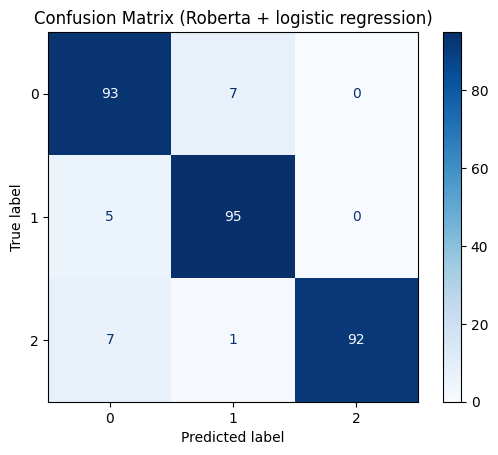

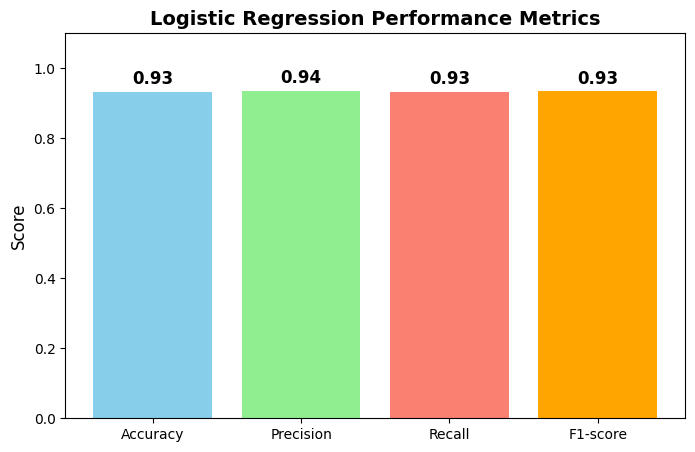

In [ ]:

y_pred = log_reg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Roberta + logistic regression)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Logistic Regression Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


**Roberta + RandomforestClassifer**

In [ ]:

from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tqdm import tqdm


MAX_LEN = 128
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


print("[INFO] Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


for layer in roberta_model.layers:
    layer.trainable = False


print("[INFO] Tokenizing texts...")
encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


print("[INFO] Generating embeddings in batches...")
embeddings_list = []
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(BATCH_SIZE)

for batch_input_ids, batch_attention_mask in tqdm(dataset, total=len(X_cleaned)//BATCH_SIZE + 1):
    outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_mask)
    # Mean pooling over token embeddings
    batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    embeddings_list.append(batch_embeddings)

cls_embeddings = tf.concat(embeddings_list, axis=0).numpy()
print(f"[INFO] Embeddings shape: {cls_embeddings.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy: {acc:.4f}")



[INFO] Loading RoBERTa model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


[INFO] Tokenizing texts...
[INFO] Generating embeddings in batches...


100%|██████████| 94/94 [13:35<00:00,  8.68s/it]


[INFO] Embeddings shape: (1500, 768)
[INFO] Training Random Forest classifier...

✅ Test Accuracy: 0.9067



Test Accuracy: 0.9067


<Figure size 600x600 with 0 Axes>

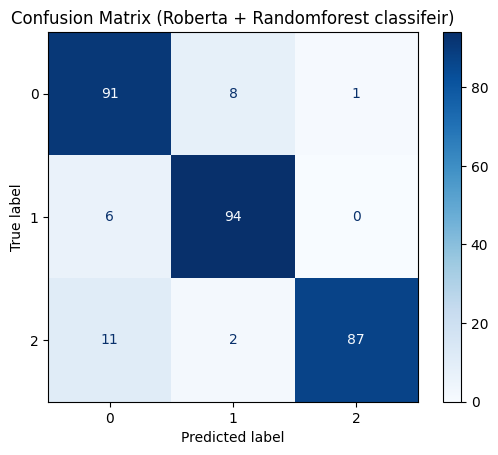

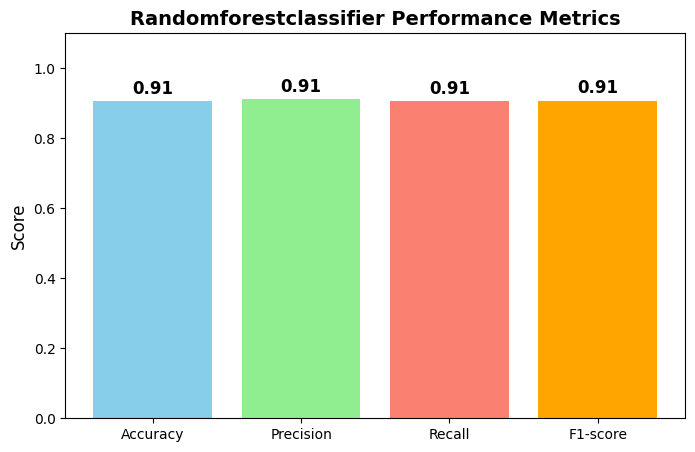

In [ ]:

y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Roberta + Randomforest classifeir)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("Randomforestclassifier Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **Roberta + xgboost**

In [ ]:


from transformers import RobertaTokenizer, TFRobertaModel
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tqdm import tqdm


MAX_LEN = 128
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


print("[INFO] Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)


for layer in roberta_model.layers:
    layer.trainable = False


print("[INFO] Tokenizing texts...")
encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


print("[INFO] Generating RoBERTa embeddings in batches...")
embeddings_list = []
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(BATCH_SIZE)

for batch_input_ids, batch_attention_mask in tqdm(dataset, total=len(X_cleaned)//BATCH_SIZE + 1):
    outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_mask)
    # Use mean pooling instead of CLS to reduce noise
    batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    embeddings_list.append(batch_embeddings)

cls_embeddings = tf.concat(embeddings_list, axis=0).numpy()
print(f"[INFO] Embeddings shape: {cls_embeddings.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y, test_size=0.2, stratify=y, random_state=42
)


print("[INFO] Training XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist',        # memory-efficient
    device='cuda' if tf.config.list_physical_devices('GPU') else 'cpu'
)

xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy: {acc:.4f}")



[INFO] Loading RoBERTa model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint 

[INFO] Tokenizing texts...
[INFO] Generating RoBERTa embeddings in batches...


100%|██████████| 94/94 [15:38<00:00,  9.98s/it]


[INFO] Embeddings shape: (1500, 768)
[INFO] Training XGBoost classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:40:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Test Accuracy: 0.9400



Test Accuracy: 0.9400


<Figure size 600x600 with 0 Axes>

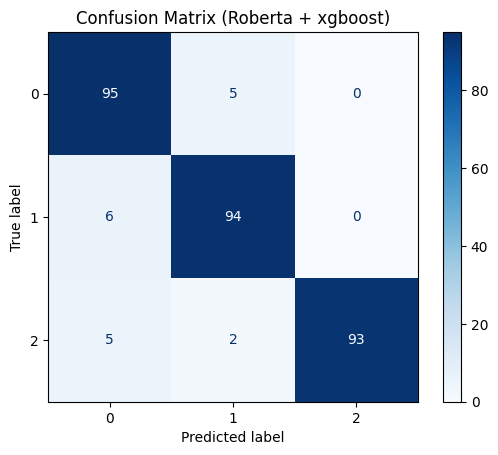

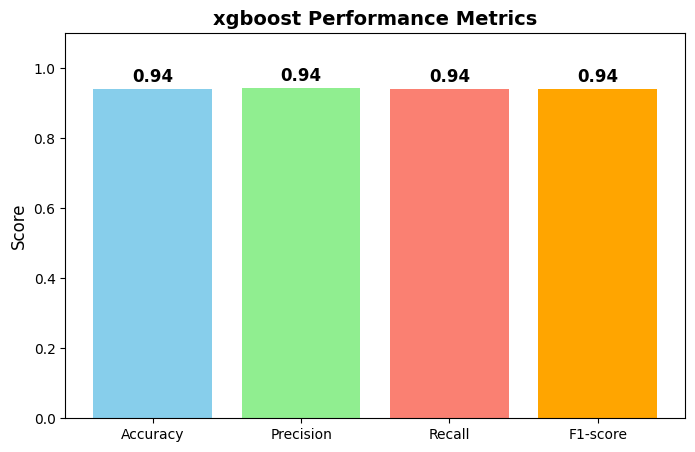

In [ ]:

y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Roberta + xgboost)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("xgboost Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()


# **Roberta + svm**

In [ ]:


from transformers import RobertaTokenizer, TFRobertaModel
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tqdm import tqdm

MAX_LEN = 128
BATCH_SIZE = 16

X_cleaned = df['text'].tolist()
y_raw = df['Category'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)


print("[INFO] Loading RoBERTa model...")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained("roberta-base", from_pt=True)

# Freeze all layers to save memory
for layer in roberta_model.layers:
    layer.trainable = False


print("[INFO] Tokenizing texts...")
encodings = tokenizer(
    X_cleaned,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="tf"
)

input_ids = encodings["input_ids"]
attention_mask = encodings["attention_mask"]


print("[INFO] Generating RoBERTa embeddings in batches...")
embeddings_list = []
dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(BATCH_SIZE)

for batch_input_ids, batch_attention_mask in tqdm(dataset, total=len(X_cleaned)//BATCH_SIZE + 1):
    outputs = roberta_model(batch_input_ids, attention_mask=batch_attention_mask)
    # Mean pooling over sequence length for stable representation
    batch_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    embeddings_list.append(batch_embeddings)

cls_embeddings = tf.concat(embeddings_list, axis=0).numpy()
print(f"[INFO] Embeddings shape: {cls_embeddings.shape}")  # (samples, 768)


X_train, X_test, y_train, y_test = train_test_split(
    cls_embeddings, y, test_size=0.2, stratify=y, random_state=42
)

print("[INFO] Training SVM classifier...")
svm_model = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n Test Accuracy: {acc:.4f}")


[INFO] Loading RoBERTa model...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


[INFO] Tokenizing texts...
[INFO] Generating RoBERTa embeddings in batches...


100%|██████████| 94/94 [16:21<00:00, 10.45s/it]


[INFO] Embeddings shape: (1500, 768)
[INFO] Training SVM classifier...

✅ Test Accuracy: 0.9533



Test Accuracy: 0.9533


<Figure size 600x600 with 0 Axes>

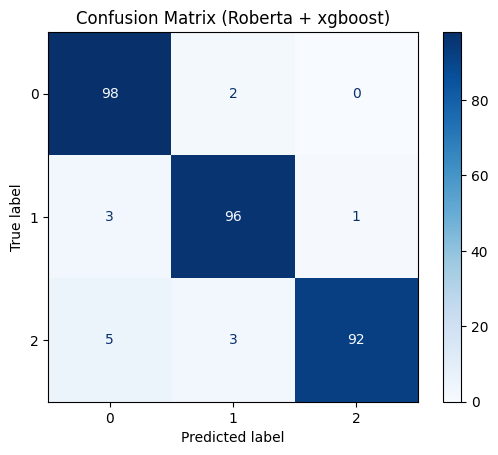

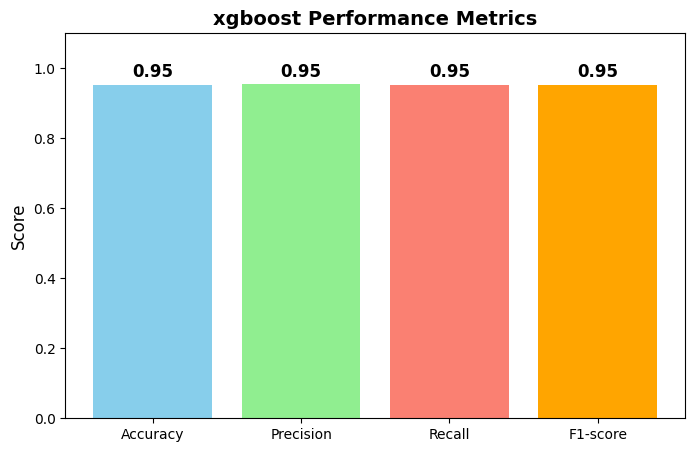

In [ ]:

y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Roberta + xgboost)")
plt.show()




acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

scores = [acc, prec, rec, f1]
labels = ["Accuracy", "Precision", "Recall", "F1-score"]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, scores, color=['skyblue','lightgreen','salmon','orange'])
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.2f}", ha='center', va='bottom', fontsize=12, fontweight="bold")
plt.ylim(0,1.1)
plt.title("xgboost Performance Metrics", fontsize=14, fontweight="bold")
plt.ylabel("Score", fontsize=12)
plt.show()
